In [1]:
# imports and basic notebook setup
from cStringIO import StringIO
import numpy as np
import os,re,random
import scipy.ndimage as nd
import PIL.Image
import PIL.ImageEnhance
import sys
from IPython.display import clear_output, Image, display
from scipy.misc import imresize
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

pycaffe_root = "/home/s/caffe/python"
sys.path.insert(0, pycaffe_root)
import caffe

model_name = "GoogLeNet"
model_path = '/home/s/caffe/models/bvlc_googlenet/'
net_fn   = './deploy_googlenet_updated.prototxt'
param_fn = model_path + 'bvlc_googlenet.caffemodel'
mean = np.float32([104.0, 117.0, 123.0])

net = caffe.Classifier(net_fn, param_fn,
                       mean = mean, # ImageNet mean, training set dependent
                       channel_swap = (2,1,0)) # the reference model has channels in BGR order instead of RGB

# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']
def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

def blur(img, sigma):
    if sigma > 0:
        img[0] = nd.filters.gaussian_filter(img[0], sigma, order=0)
        img[1] = nd.filters.gaussian_filter(img[1], sigma, order=0)
        img[2] = nd.filters.gaussian_filter(img[2], sigma, order=0)
    return img

def bilateralFilter_and_Blur(img, sigma):
    img[0] = cv2.bilateralFilter(nd.filters.gaussian_filter(img[0], sigma, order=0), 5, 5, 5)
    img[1] = cv2.bilateralFilter(nd.filters.gaussian_filter(img[1], sigma, order=0), 5, 5, 5)
    img[2] = cv2.bilateralFilter(nd.filters.gaussian_filter(img[2], sigma, order=0), 5, 5, 5)
    return img

def no_blur(img, sigma):
    # do nothing
    return img

def showarray(a, f, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

Definition of the main gradient ascent functions. Based on the [deepdream code](https://github.com/google/deepdream/blob/master/dream.ipynb) published by Google.

In [6]:
def make_step(net, step_size=1.5, end='inception_4c/output', clip=True, focus=None, sigma=None):
    '''Basic gradient ascent step.'''

    src = net.blobs['data'] # input image is stored in Net's 'data' blob
    
    dst = net.blobs[end]
    net.forward(end=end)

    one_hot = np.zeros_like(dst.data)
    one_hot.flat[focus] = 1.
    dst.diff[:] = one_hot

    net.backward(start=end)
    g = src.diff[0]
    
    src.data[:] += step_size/np.abs(g).mean() * g

    if clip:
        bias = net.transformer.mean['data']
        src.data[:] = np.clip(src.data, -bias, 255-bias) 
    
    src.data[0] = bilateralFilter_and_Blur(src.data[0], sigma)  # Approach #3 (blur + bilateralFilter)
    # src.data[0] = blur(src.data[0], sigma)                    # Approach #3 (only blur)
    # src.data[0] = no_blur(src.data[0], sigma)                 # Approach #2
    
    # reset objective for next step
    dst.diff.fill(0.)

def deepdraw(net, base_img, octaves, random_crop=True, visualize=True, focus=None,
    clip=True, **step_params):
    
    # prepare base image
    image = preprocess(net, base_img)
    
    # get input dimensions from net
    w = net.blobs['data'].width
    h = net.blobs['data'].height
    
    print "starting drawing"
    src = net.blobs['data']
    src.reshape(1,3,h,w)                                    # reshape the network's input image size
    for e,o in enumerate(octaves):                          # scale up image if specified in octaves
        if 'scale' in o:
            # resize by o['scale'] if it exists
            image = nd.zoom(image, (1,o['scale'],o['scale']))
        _,imw,imh = image.shape
        
        # select layer
        layer = o['layer']

        for i in xrange(o['iter_n']):
            if imw > w:
                if random_crop:
                    # randomly select a crop 
                    mid_x = (imw-w)/2.
                    width_x = imw-w
                    ox = np.random.normal(mid_x, width_x*0.3, 1)
                    ox = int(np.clip(ox,0,imw-w))
                    mid_y = (imh-h)/2.
                    width_y = imh-h
                    oy = np.random.normal(mid_y, width_y*0.3, 1)
                    oy = int(np.clip(oy,0,imh-h))
                    # insert the crop into src.data[0]
                    src.data[0] = image[:,ox:ox+w,oy:oy+h]
                else:
                    ox = (imw-w)/2.
                    oy = (imh-h)/2.
                    src.data[0] = image[:,ox:ox+w,oy:oy+h]
            else:
                ox = 0
                oy = 0
                src.data[0] = image.copy()

            sigma = o['start_sigma'] + ((o['end_sigma'] - o['start_sigma']) * i) / o['iter_n']
            step_size = o['start_step_size'] + ((o['end_step_size'] - o['start_step_size']) * i) / o['iter_n']
            
            make_step(net, end=layer, clip=clip, focus=focus, 
                      sigma=sigma, step_size=step_size)
            
            if visualize:
                vis = deprocess(net, src.data[0])
                if not clip: # adjust image contrast if clipping is disabled
                    vis = vis*(255.0/np.percentile(vis, 99.98))
                if i % 1 == 0:
                    showarray(vis,"./filename"+str(i)+".jpg")
            
            if i % 10 == 0:
                print 'finished step %d in octave %d' % (i,e)
            
            # insert modified image back into original image (if necessary)
            image[:,ox:ox+w,oy:oy+h] = src.data[0]
        
        print "octave %d image:" % e
        showarray(deprocess(net, image),"./octave_"+str(e)+".jpg")
            
    # returning the resulting image
    return np.uint8(deprocess(net, image))

#### Generating the class visualizations

* ```layer``` : which layer to optimize
* ```iter_n``` : how many iterations
* ```scale``` : by what factor (if any) to scale up the base image before proceeding
* ```start_sigma``` : the initial radius of the gaussian blur
* ```end_sigma``` : the final radius of the gaussian blur
* ```start_step_size``` : the initial step size of the gradient ascent
* ```end_step_size``` : the final step size of the gradient ascent

starting drawing


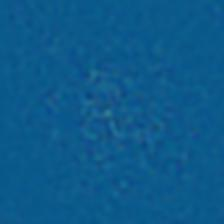

finished step 0 in octave 0


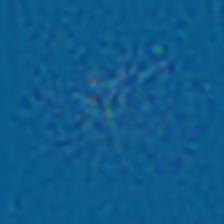

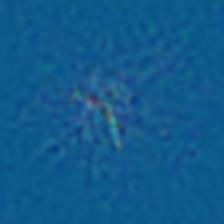

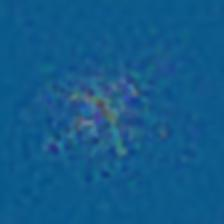

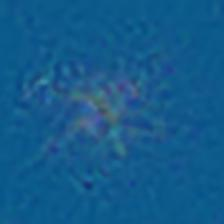

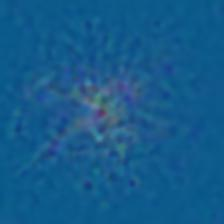

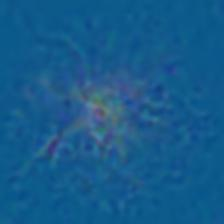

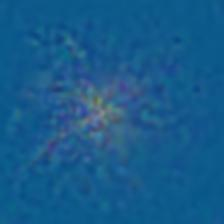

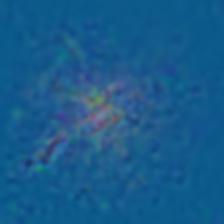

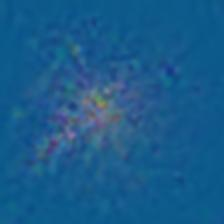

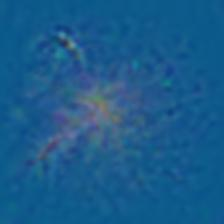

finished step 10 in octave 0


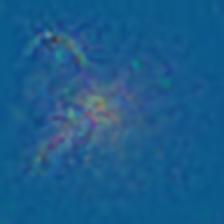

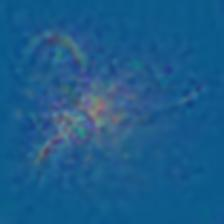

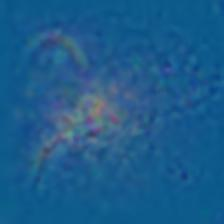

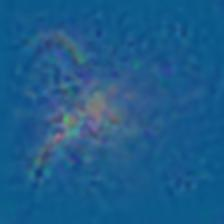

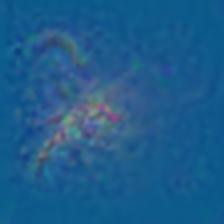

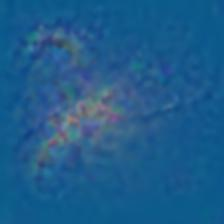

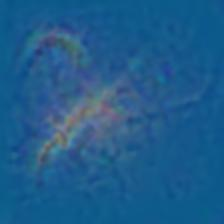

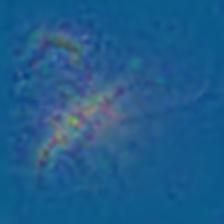

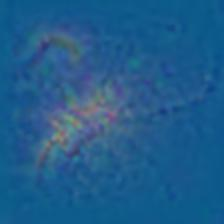

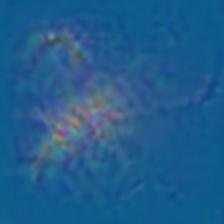

finished step 20 in octave 0


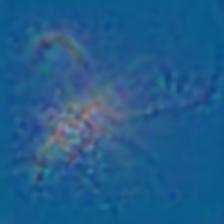

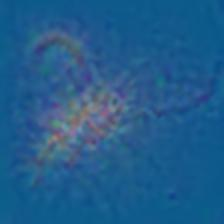

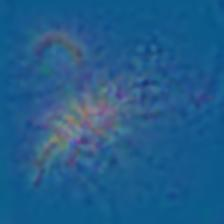

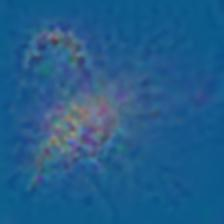

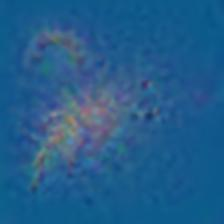

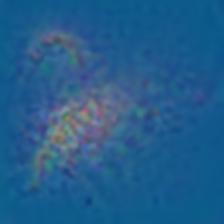

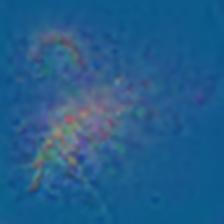

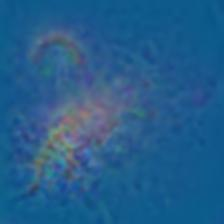

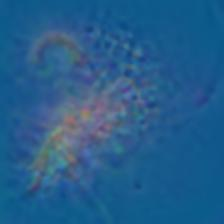

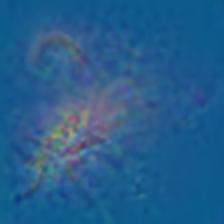

finished step 30 in octave 0


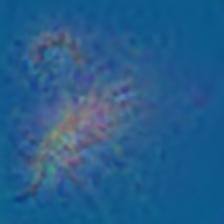

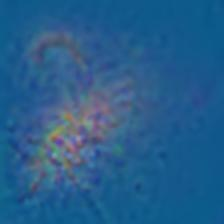

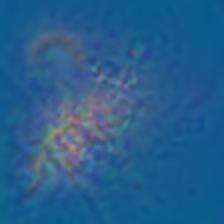

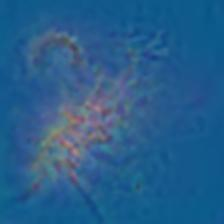

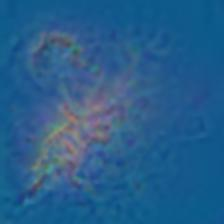

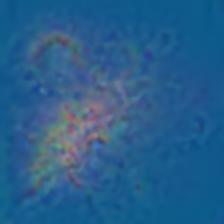

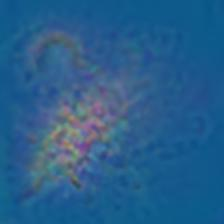

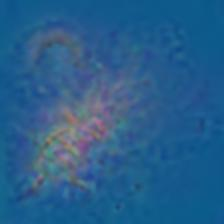

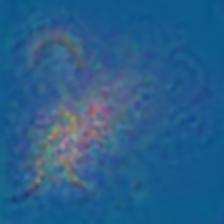

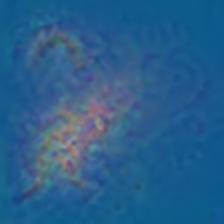

finished step 40 in octave 0


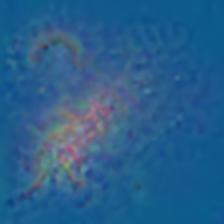

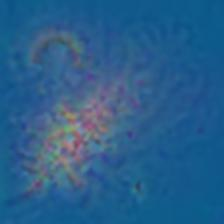

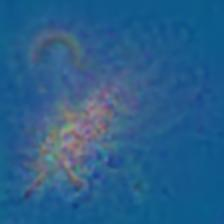

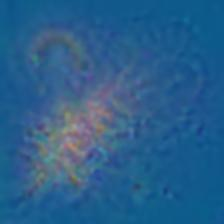

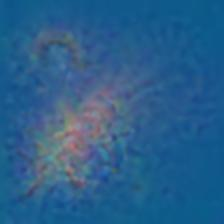

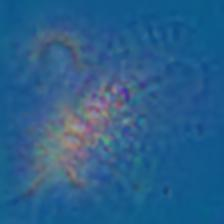

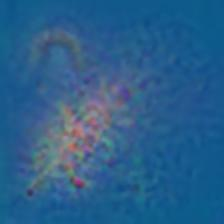

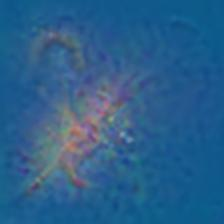

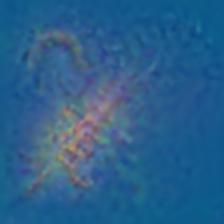

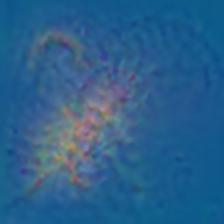

finished step 50 in octave 0


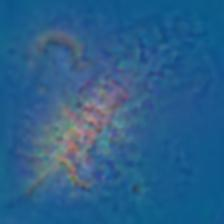

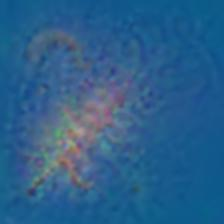

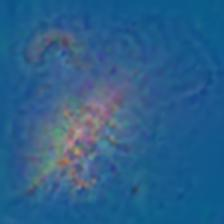

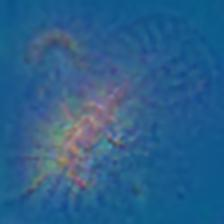

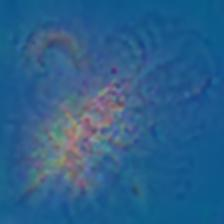

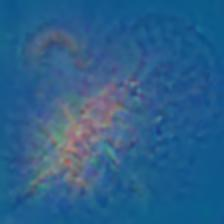

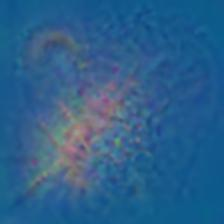

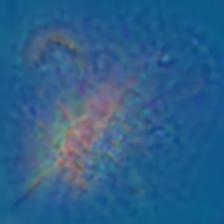

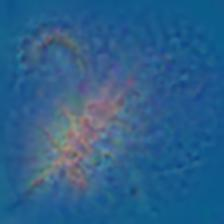

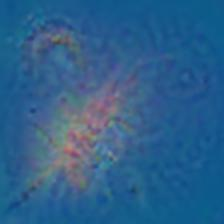

finished step 60 in octave 0


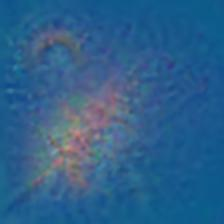

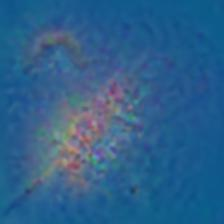

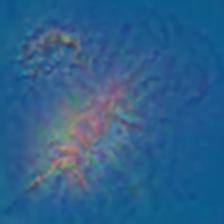

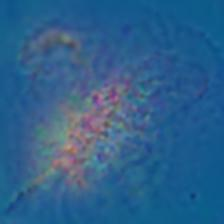

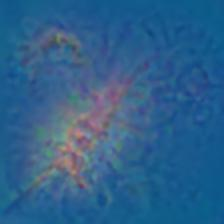

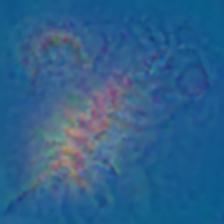

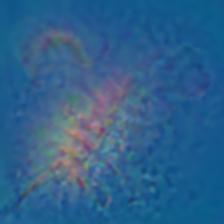

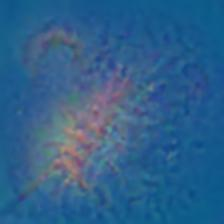

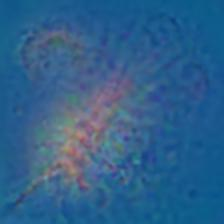

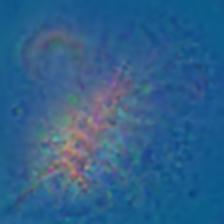

finished step 70 in octave 0


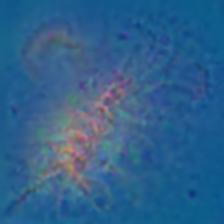

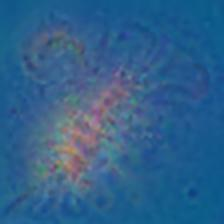

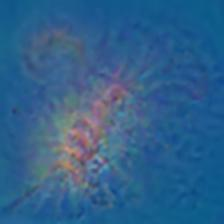

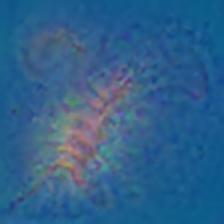

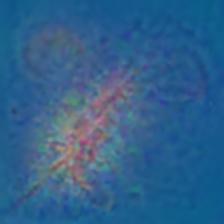

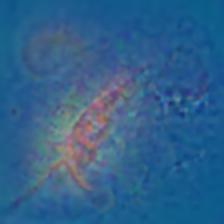

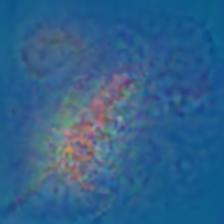

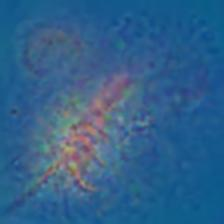

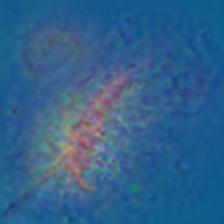

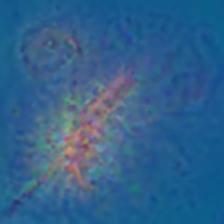

finished step 80 in octave 0


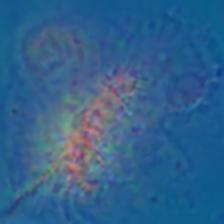

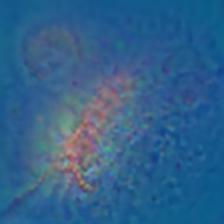

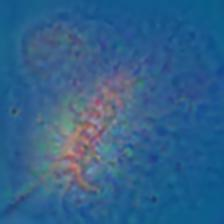

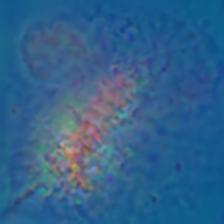

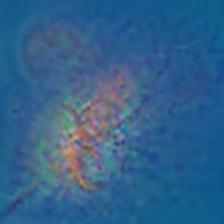

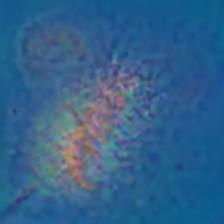

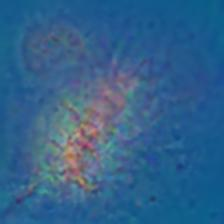

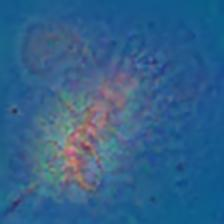

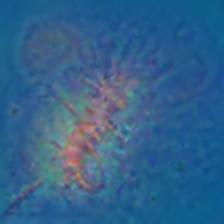

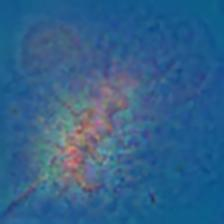

finished step 90 in octave 0


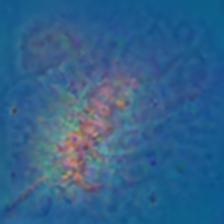

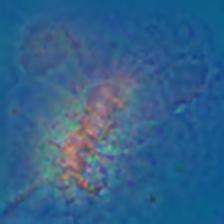

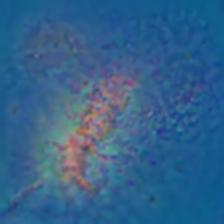

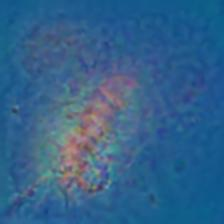

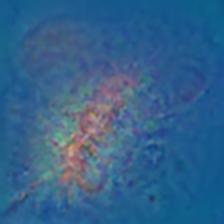

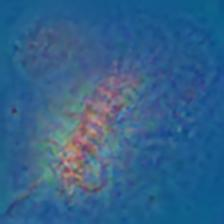

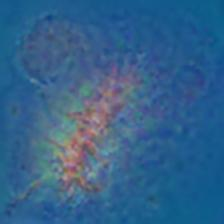

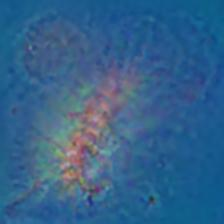

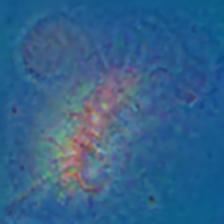

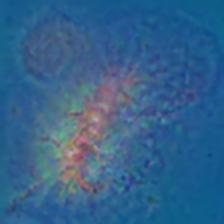

finished step 100 in octave 0


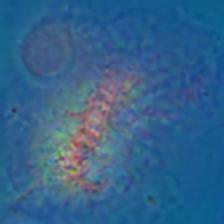

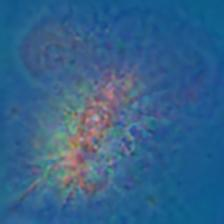

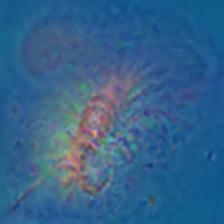

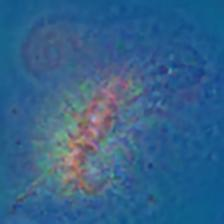

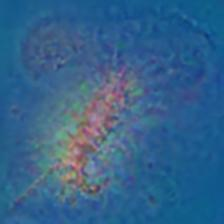

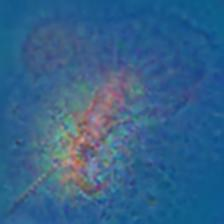

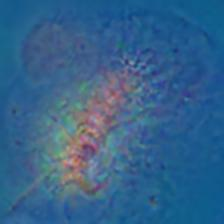

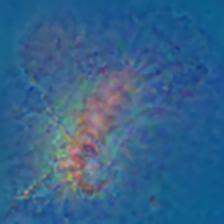

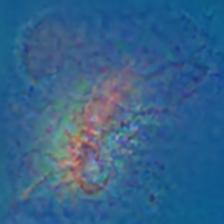

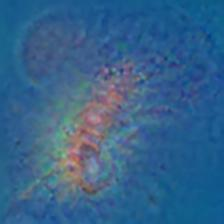

finished step 110 in octave 0


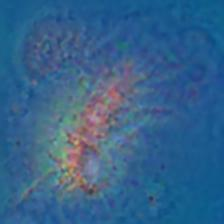

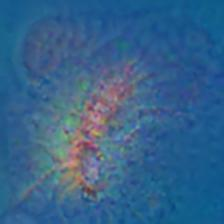

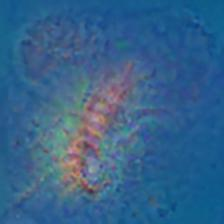

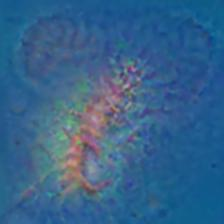

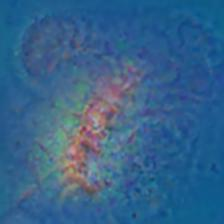

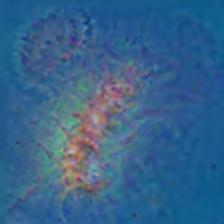

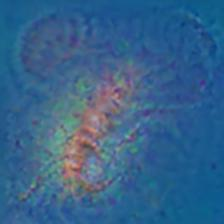

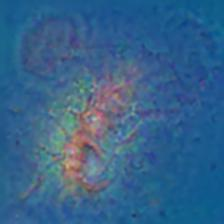

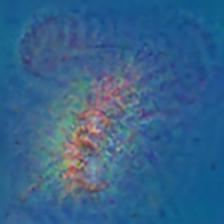

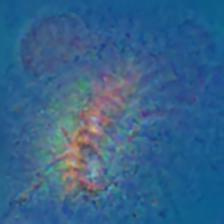

finished step 120 in octave 0


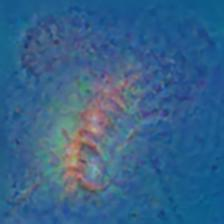

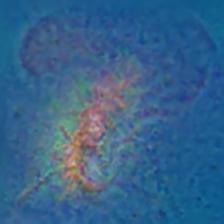

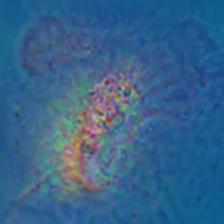

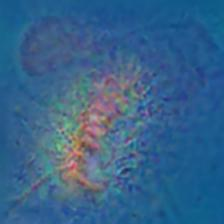

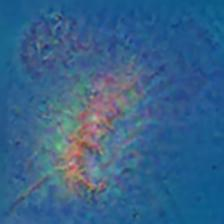

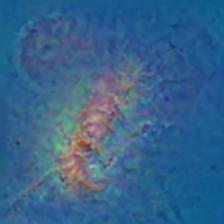

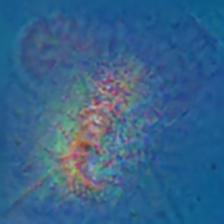

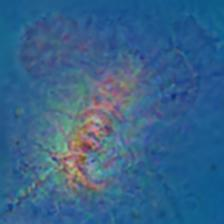

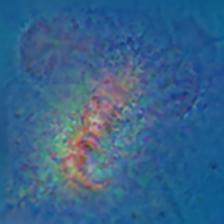

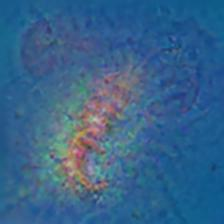

finished step 130 in octave 0


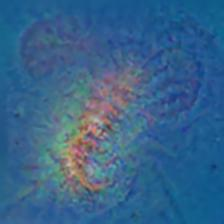

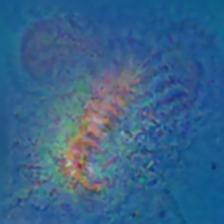

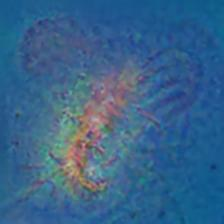

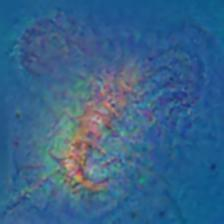

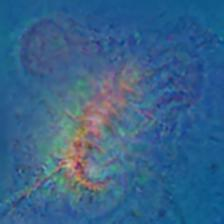

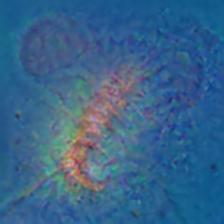

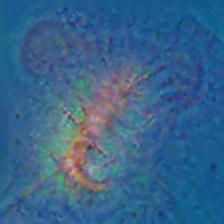

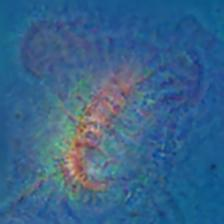

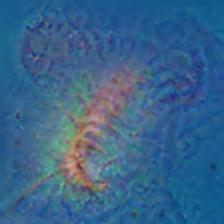

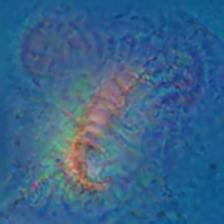

finished step 140 in octave 0


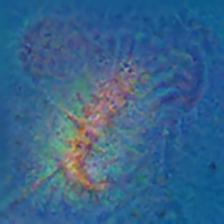

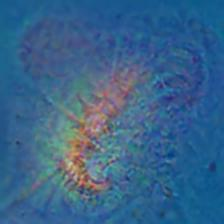

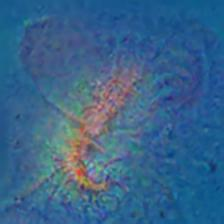

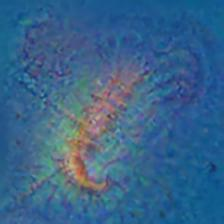

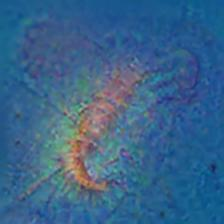

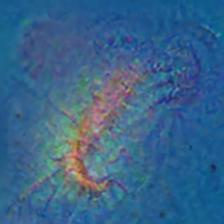

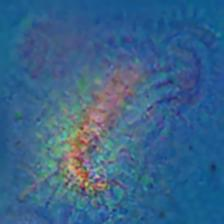

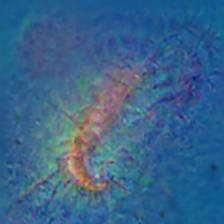

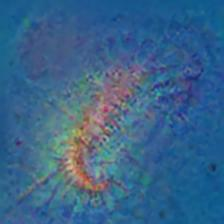

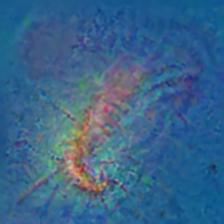

finished step 150 in octave 0


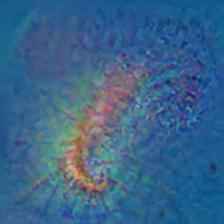

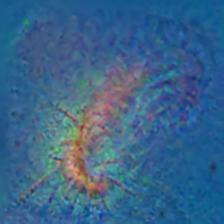

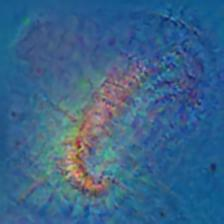

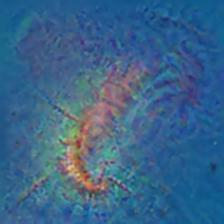

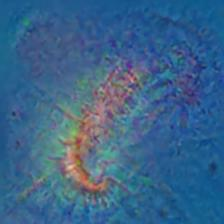

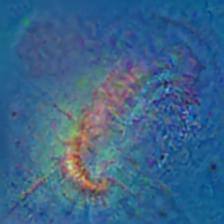

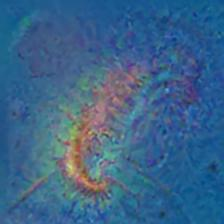

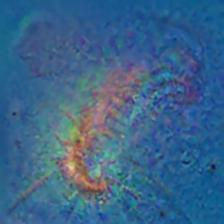

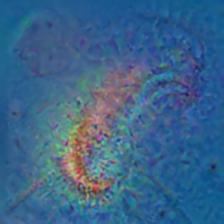

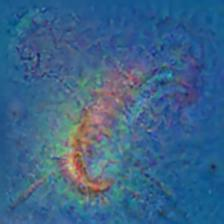

finished step 160 in octave 0


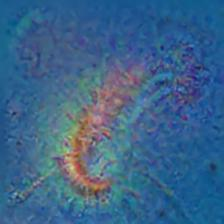

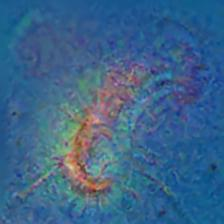

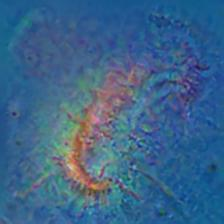

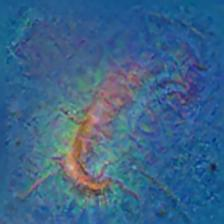

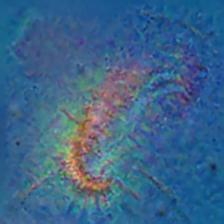

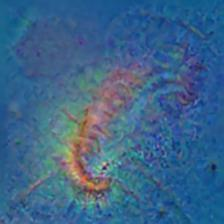

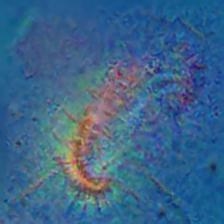

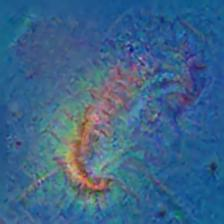

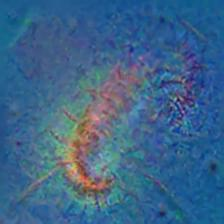

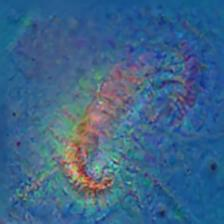

finished step 170 in octave 0


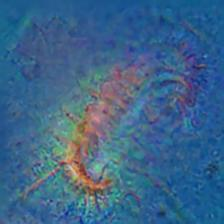

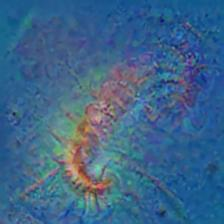

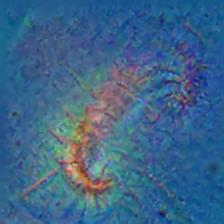

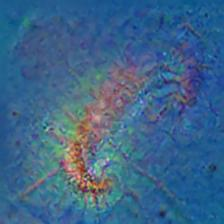

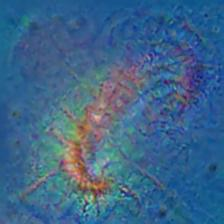

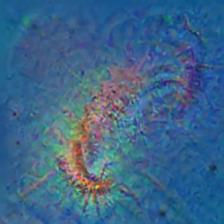

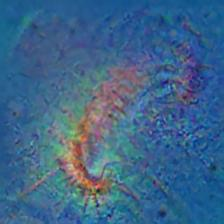

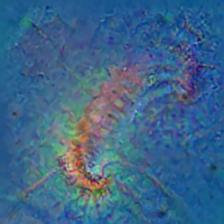

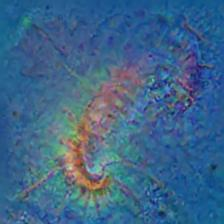

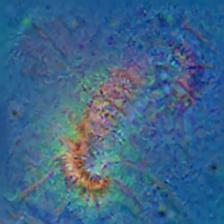

finished step 180 in octave 0


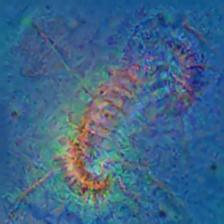

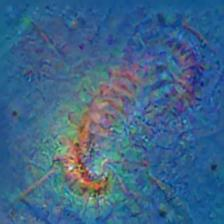

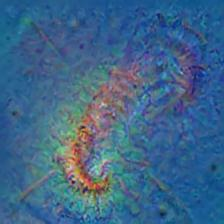

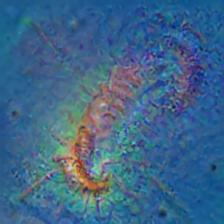

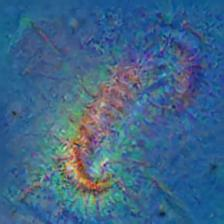

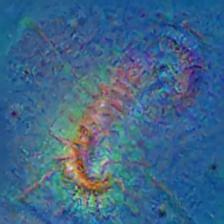

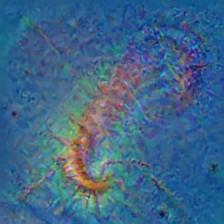

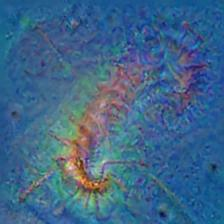

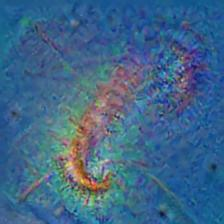

octave 0 image:


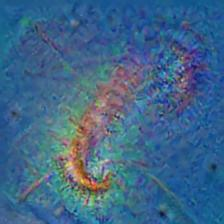

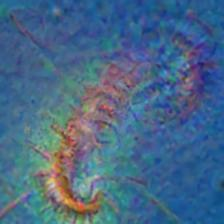

finished step 0 in octave 1


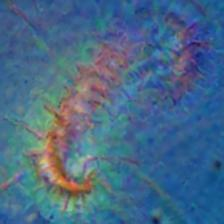

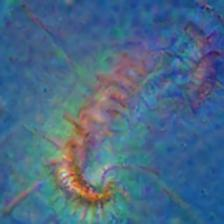

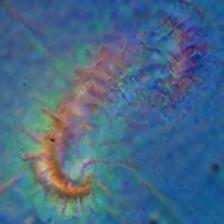

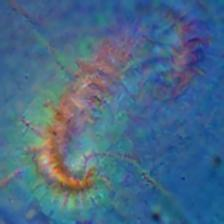

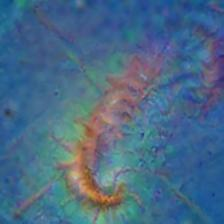

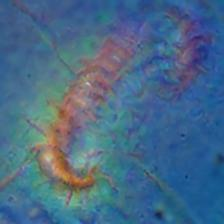

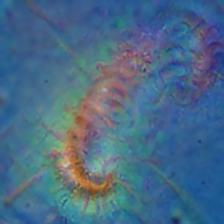

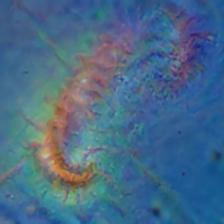

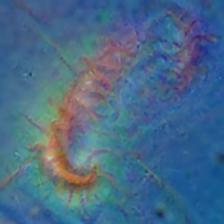

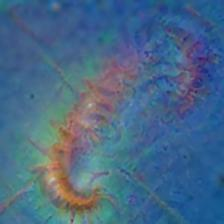

finished step 10 in octave 1


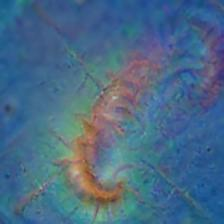

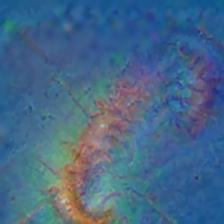

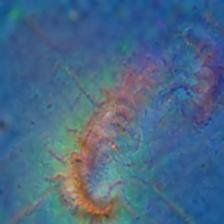

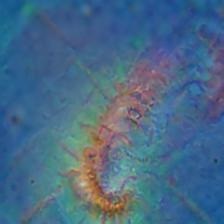

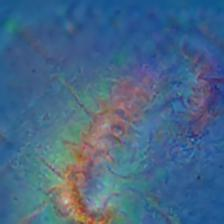

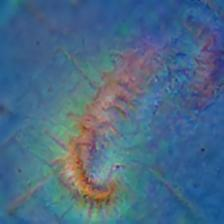

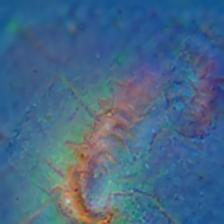

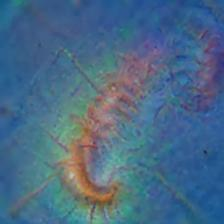

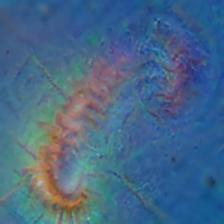

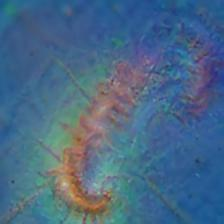

finished step 20 in octave 1


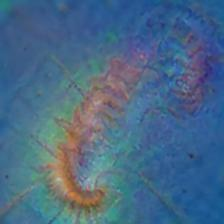

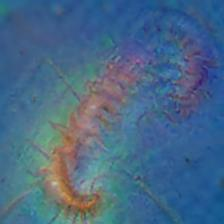

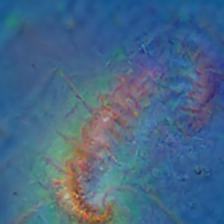

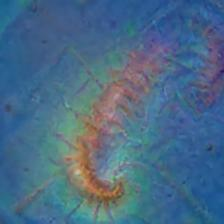

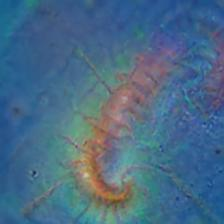

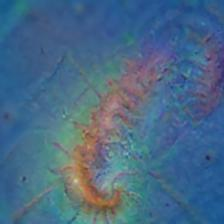

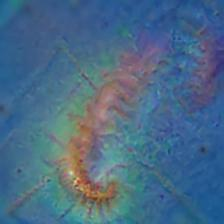

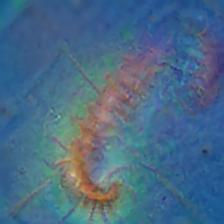

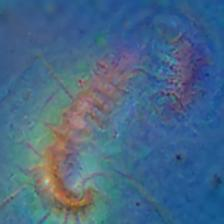

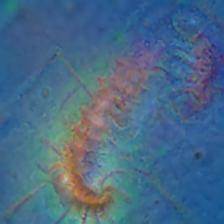

finished step 30 in octave 1


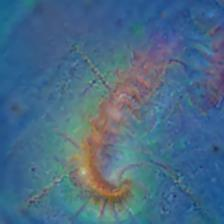

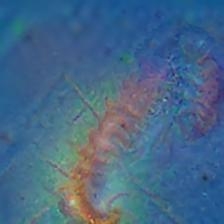

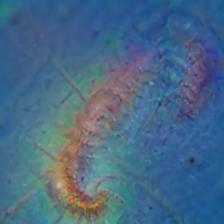

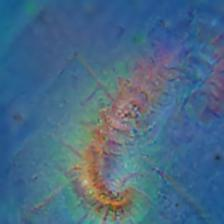

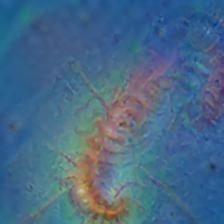

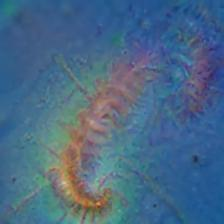

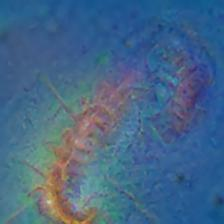

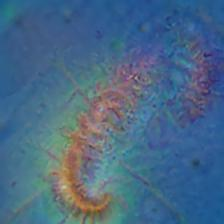

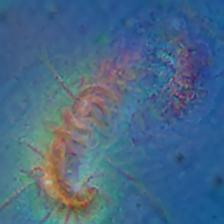

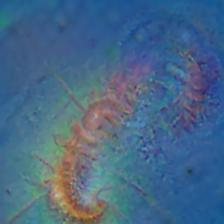

finished step 40 in octave 1


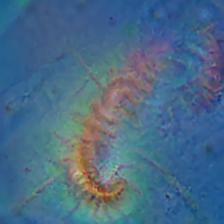

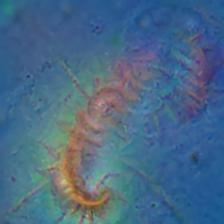

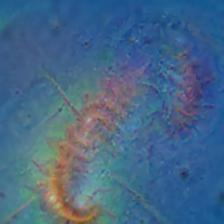

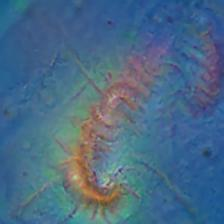

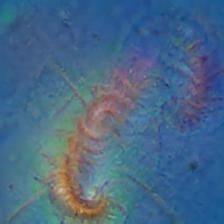

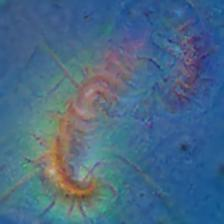

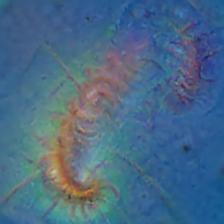

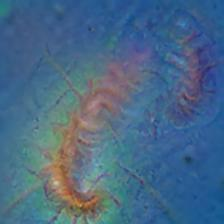

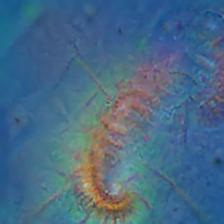

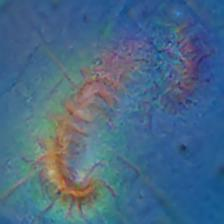

finished step 50 in octave 1


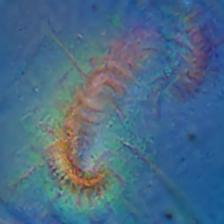

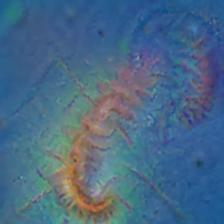

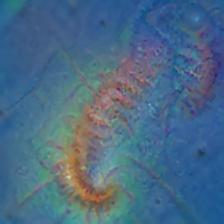

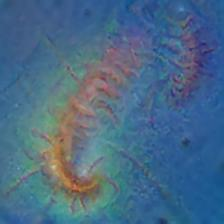

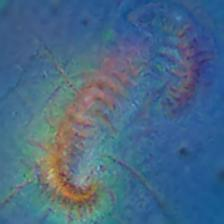

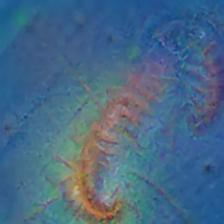

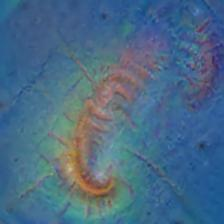

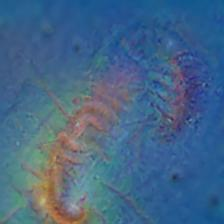

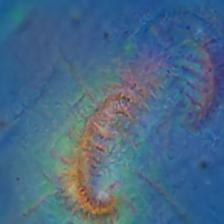

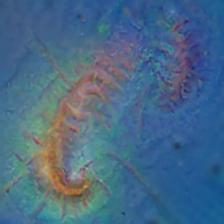

finished step 60 in octave 1


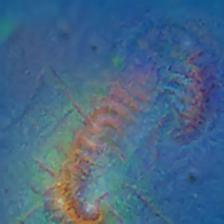

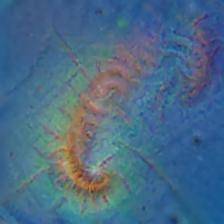

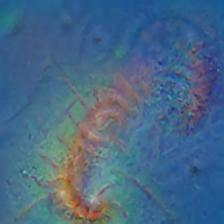

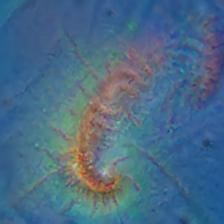

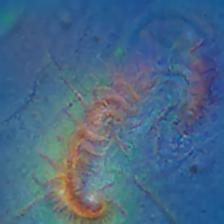

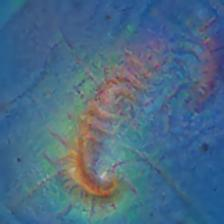

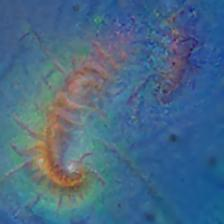

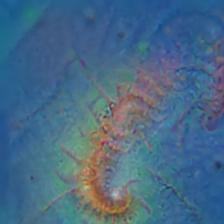

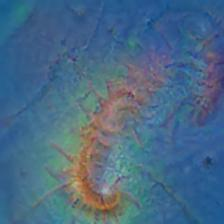

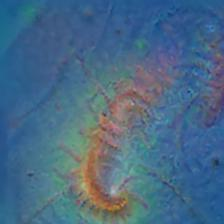

finished step 70 in octave 1


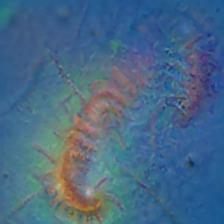

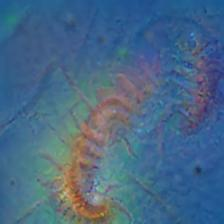

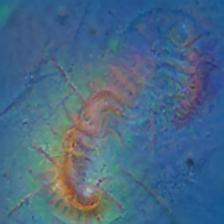

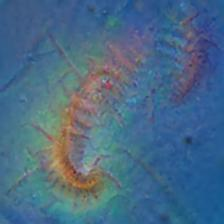

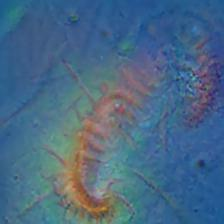

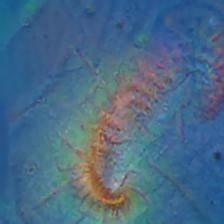

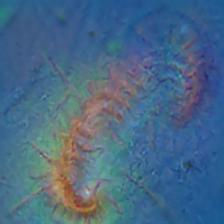

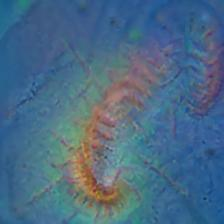

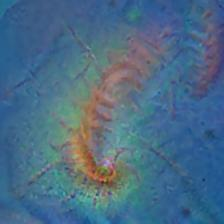

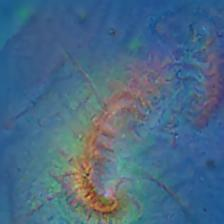

finished step 80 in octave 1


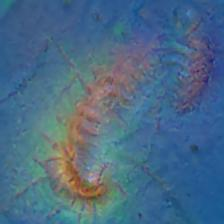

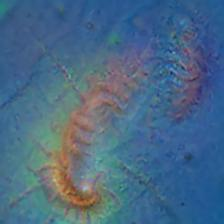

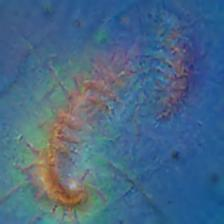

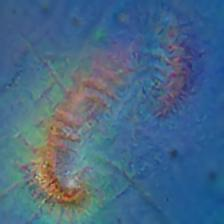

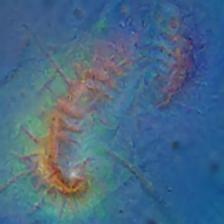

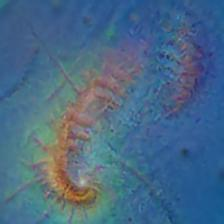

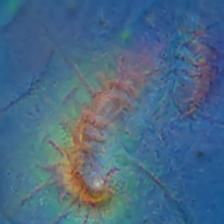

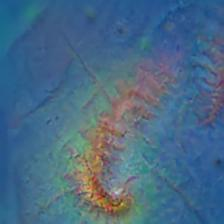

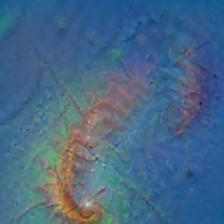

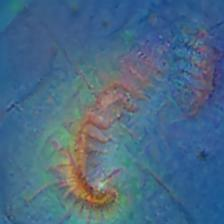

finished step 90 in octave 1


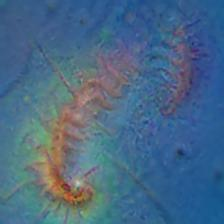

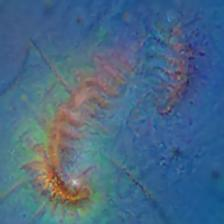

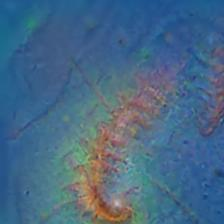

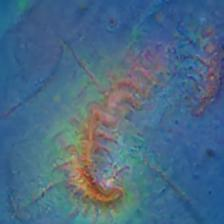

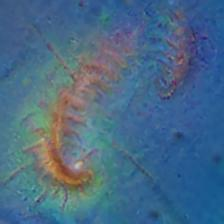

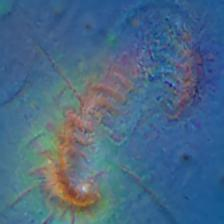

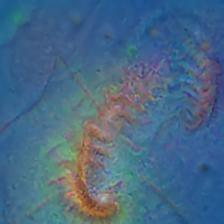

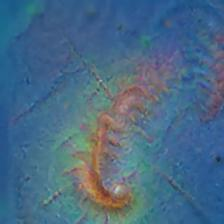

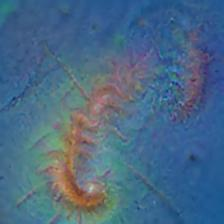

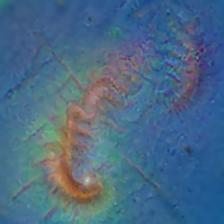

finished step 100 in octave 1


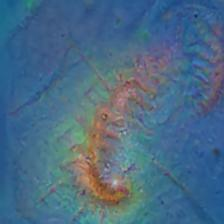

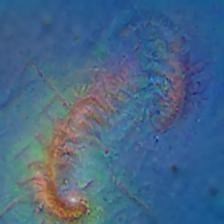

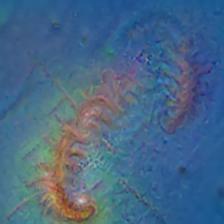

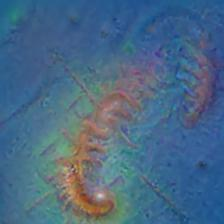

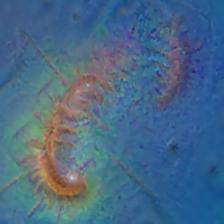

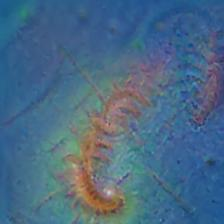

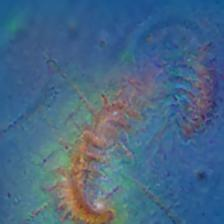

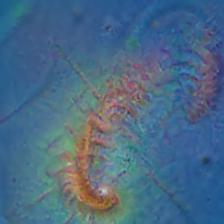

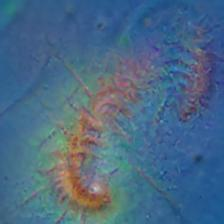

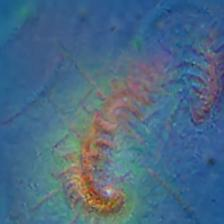

finished step 110 in octave 1


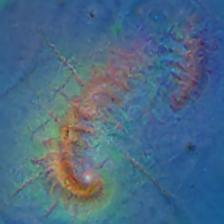

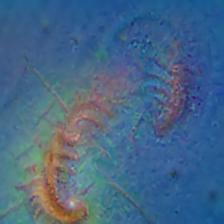

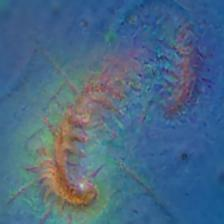

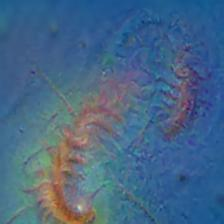

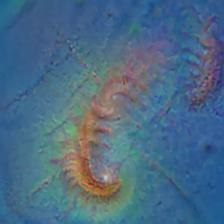

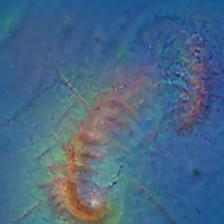

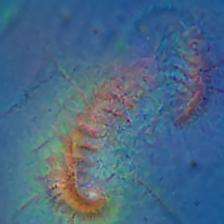

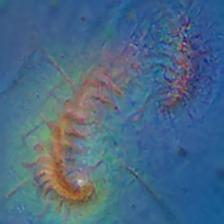

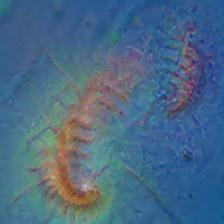

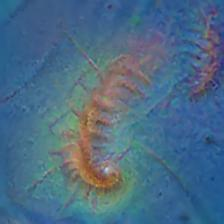

finished step 120 in octave 1


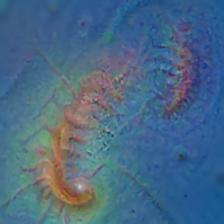

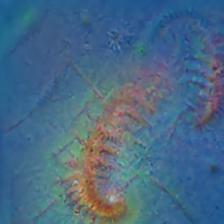

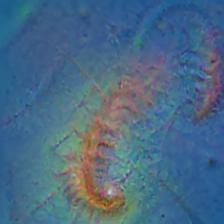

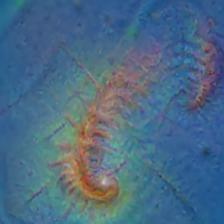

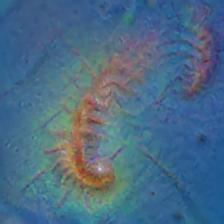

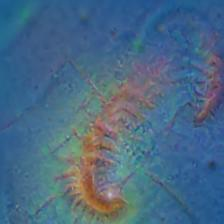

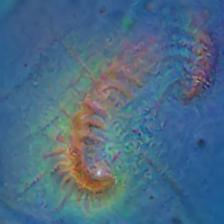

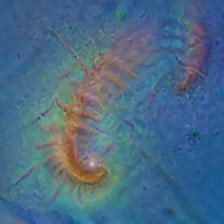

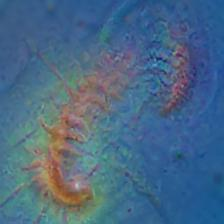

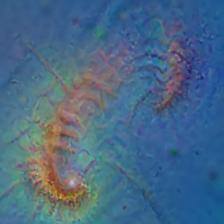

finished step 130 in octave 1


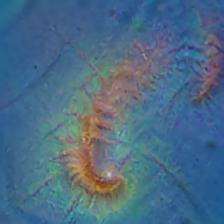

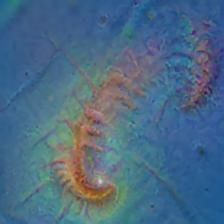

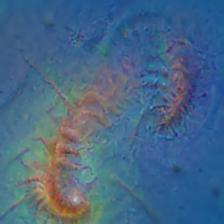

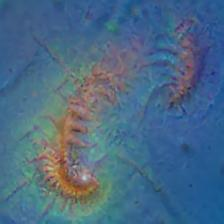

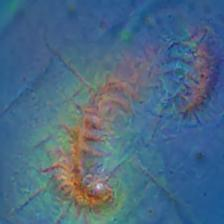

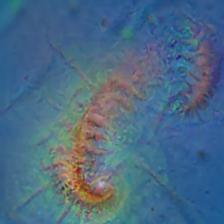

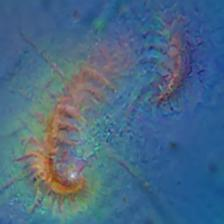

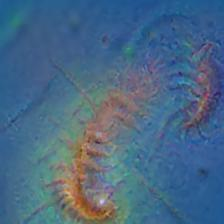

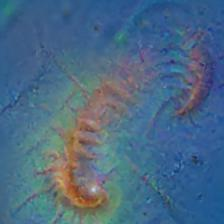

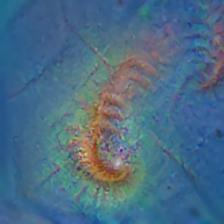

finished step 140 in octave 1


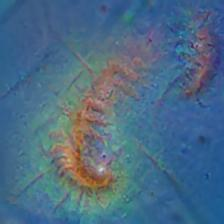

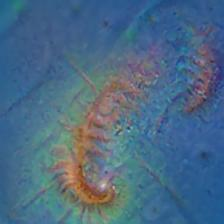

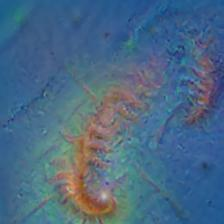

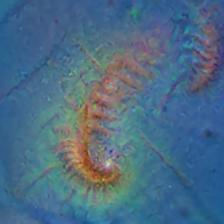

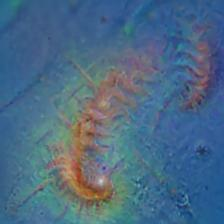

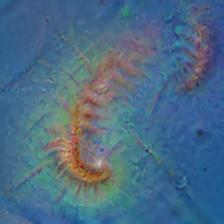

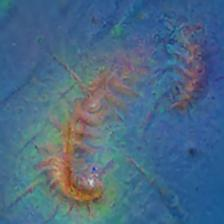

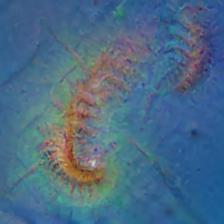

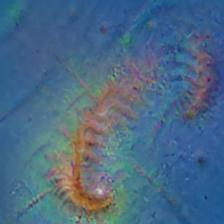

octave 1 image:


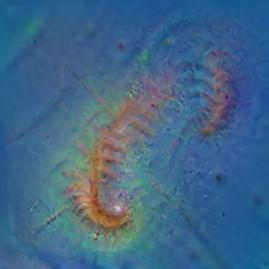

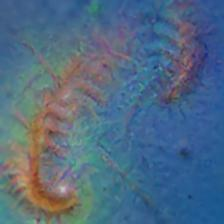

finished step 0 in octave 2


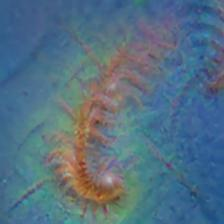

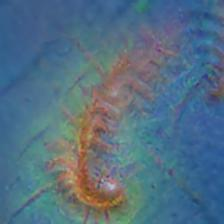

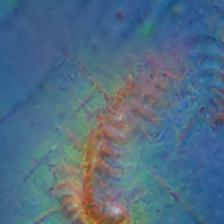

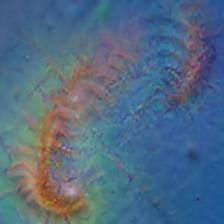

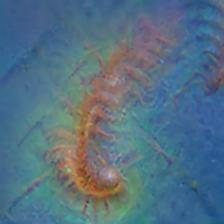

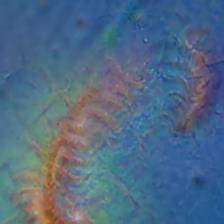

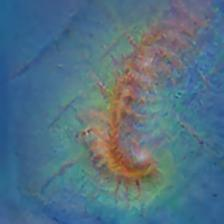

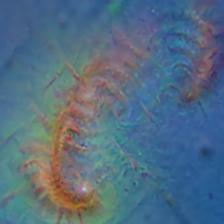

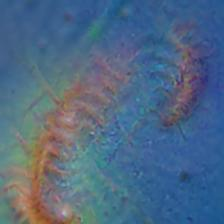

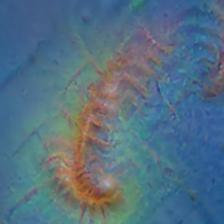

finished step 10 in octave 2


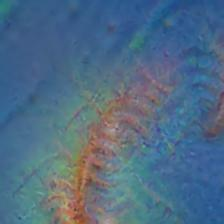

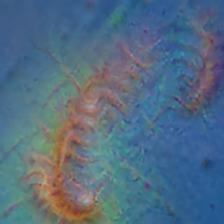

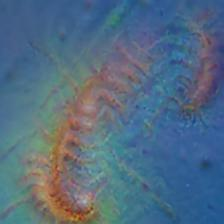

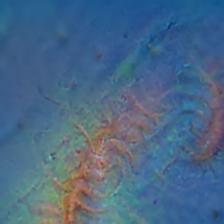

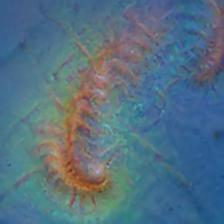

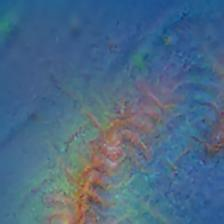

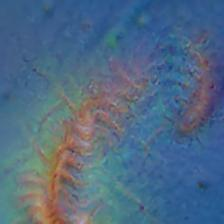

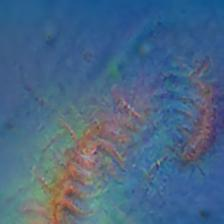

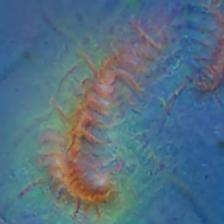

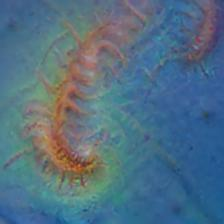

finished step 20 in octave 2


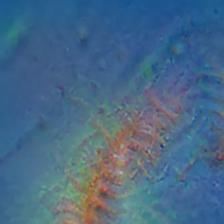

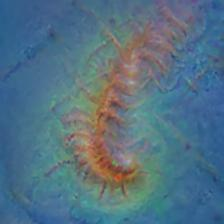

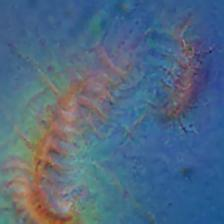

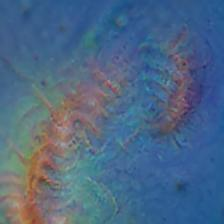

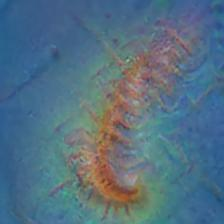

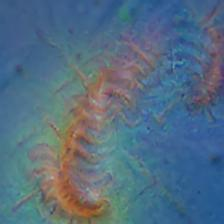

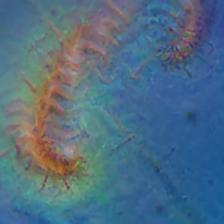

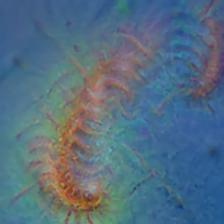

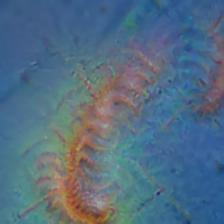

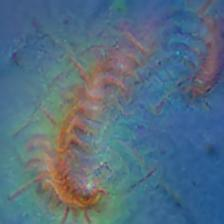

finished step 30 in octave 2


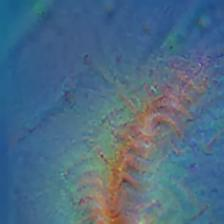

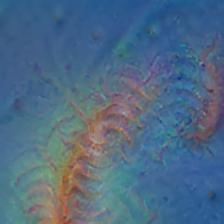

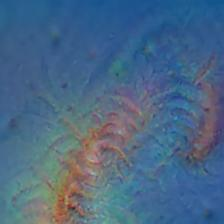

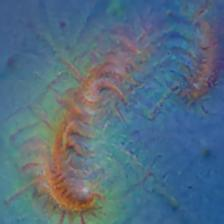

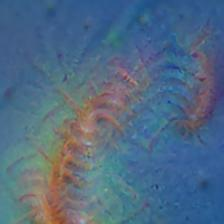

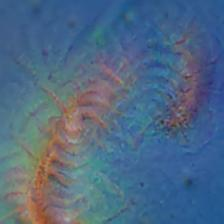

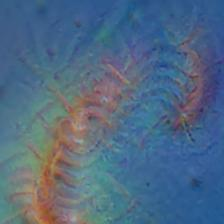

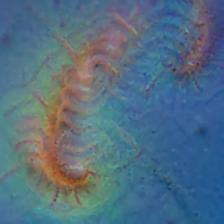

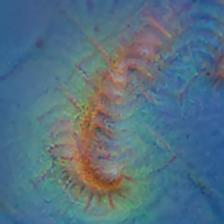

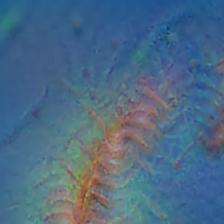

finished step 40 in octave 2


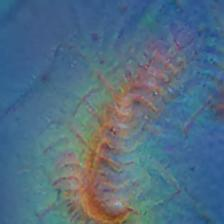

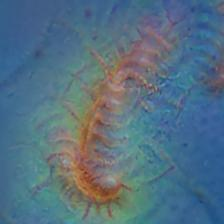

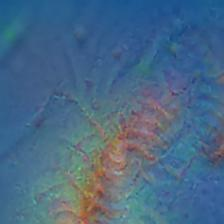

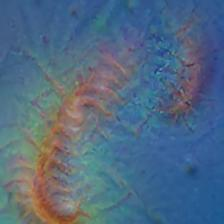

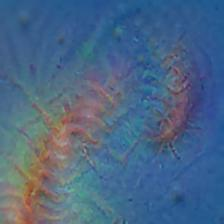

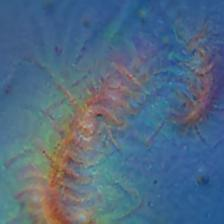

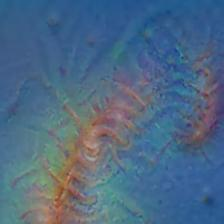

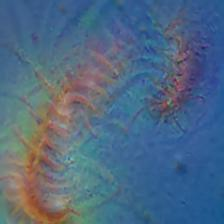

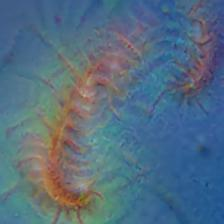

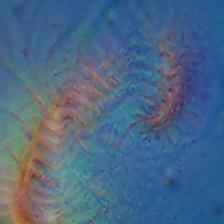

finished step 50 in octave 2


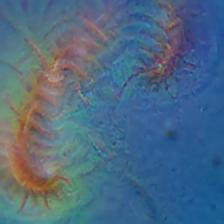

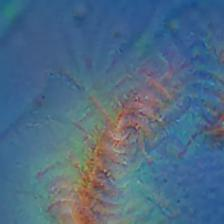

KeyboardInterrupt: 

In [7]:
octaves = [
    {
        'layer':'loss3/classifier',
        'iter_n':190,
        'start_sigma':2.5,
        'end_sigma':0.78,
        'start_step_size':11.,
        'end_step_size':11.
    },
    {
        'layer':'loss3/classifier',
        'scale':1.2,
        'iter_n':150,
        'start_sigma':0.78*1.2,
        'end_sigma':0.78,
        'start_step_size':6.,
        'end_step_size':6.
    },
    {
        'layer':'loss2/classifier',
        'scale':1.2,
        'iter_n':150,
        'start_sigma':0.78*1.2,
        'end_sigma':0.44,
        'start_step_size':6.,
        'end_step_size':3.
    },
    {
        'layer':'loss1/classifier',
        'iter_n':10,
        'start_sigma':0.44,
        'end_sigma':0.304,
        'start_step_size':3.,
        'end_step_size':3.
    }
]

# get original image input size from network
original_w = net.blobs['data'].width
original_h = net.blobs['data'].height
# the background color of the initial image
# background_color = np.float32([28.0, 84.0, 122.0]) # This is blue 
# background_color = np.float32([54.0, 42.0, 77.0]) # This is dark purple 
background_color = np.float32([10, 90, 140])

imagenet_class = 79
gen_image = np.random.normal(background_color, 8, (original_w, original_h, 3)) # create image of random noise with dimensions of input image
gen_image = deepdraw(net, gen_image, octaves, focus=imagenet_class, random_crop=True, visualize=True)
img_fn = '_'.join([model_name, "deepdraw_denoised", str(imagenet_class)+'.png'])

In [ ]:
octaves = [
    {
        'layer':'loss3/classifier',
        'iter_n':190,
        'start_sigma':2.5,
        'end_sigma':0.78,
        'start_step_size':11.,
        'end_step_size':11.
    },
    {
        'layer':'loss3/classifier',
        'scale':1.2,
        'iter_n':150,
        'start_sigma':0.78*1.2,
        'end_sigma':0.78,
        'start_step_size':6.,
        'end_step_size':6.
    },
    {
        'layer':'loss2/classifier',
        'scale':1.2,
        'iter_n':150,
        'start_sigma':0.78*1.2,
        'end_sigma':0.44,
        'start_step_size':6.,
        'end_step_size':3.
    },
    {
        'layer':'loss1/classifier',
        'iter_n':10,
        'start_sigma':0.44,
        'end_sigma':0.304,
        'start_step_size':3.,
        'end_step_size':3.
    }
]

# get original image input size from network
original_w = net.blobs['data'].width
original_h = net.blobs['data'].height
# the background color of the initial image
# background_color = np.float32([28.0, 84.0, 122.0]) # This is blue 
# background_color = np.float32([54.0, 42.0, 77.0]) # This is dark purple 
background_color = np.float32([10, 90, 140])

imagenet_class = 79
gen_image = np.random.normal(background_color, 8, (original_w, original_h, 3)) # create image of random noise with dimensions of input image
gen_image = deepdraw(net, gen_image, octaves, focus=imagenet_class, random_crop=True)
img_fn = '_'.join([model_name, "deepdraw_denoised", str(imagenet_class)+'.png'])

starting drawing
finished step 0 in octave 0
finished step 10 in octave 0
finished step 20 in octave 0
finished step 30 in octave 0
finished step 40 in octave 0
finished step 50 in octave 0
finished step 60 in octave 0
finished step 70 in octave 0
finished step 80 in octave 0
finished step 90 in octave 0
finished step 100 in octave 0
finished step 110 in octave 0
finished step 120 in octave 0
finished step 130 in octave 0
finished step 140 in octave 0
finished step 150 in octave 0
finished step 160 in octave 0
finished step 170 in octave 0
finished step 180 in octave 0
octave 0 image:


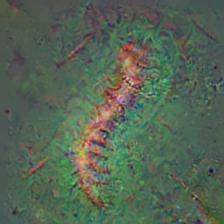

finished step 0 in octave 1
finished step 10 in octave 1
finished step 20 in octave 1
finished step 30 in octave 1
finished step 40 in octave 1
finished step 50 in octave 1
finished step 60 in octave 1
finished step 70 in octave 1
finished step 80 in octave 1
finished step 90 in octave 1
finished step 100 in octave 1
finished step 110 in octave 1
finished step 120 in octave 1
finished step 130 in octave 1
finished step 140 in octave 1
octave 1 image:


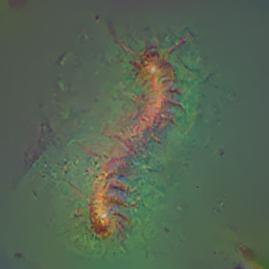

finished step 0 in octave 2
finished step 10 in octave 2
finished step 20 in octave 2
finished step 30 in octave 2
finished step 40 in octave 2
finished step 50 in octave 2
finished step 60 in octave 2
octave 2 image:


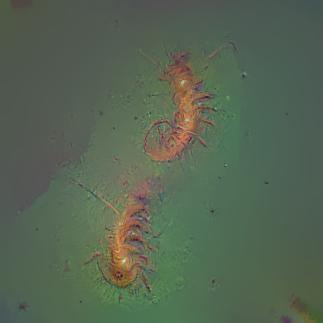

finished step 0 in octave 3
finished step 10 in octave 3
finished step 20 in octave 3
finished step 30 in octave 3
finished step 40 in octave 3
octave 3 image:


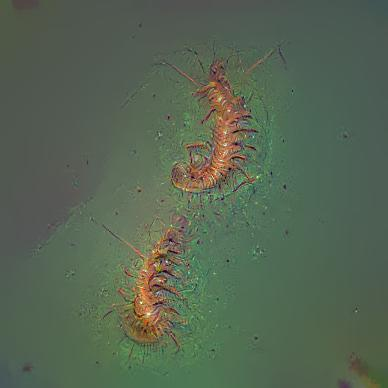

finished step 0 in octave 4
finished step 10 in octave 4
finished step 20 in octave 4
octave 4 image:


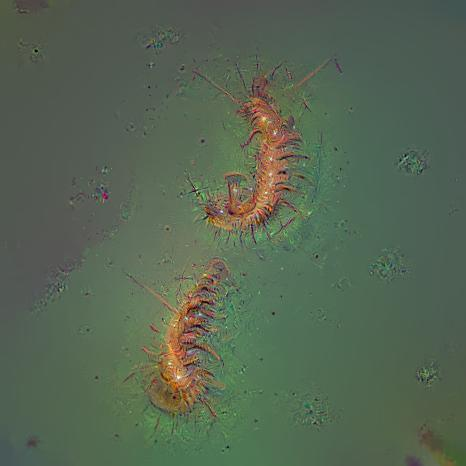

finished step 0 in octave 5
finished step 10 in octave 5
finished step 20 in octave 5
finished step 30 in octave 5
finished step 40 in octave 5
finished step 50 in octave 5
finished step 60 in octave 5
finished step 70 in octave 5
finished step 80 in octave 5
finished step 90 in octave 5
finished step 100 in octave 5
finished step 110 in octave 5
finished step 120 in octave 5
finished step 130 in octave 5
finished step 140 in octave 5
octave 5 image:


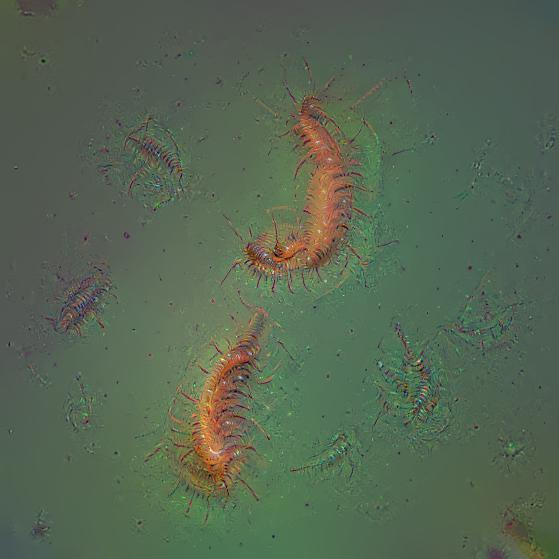

finished step 0 in octave 6
finished step 10 in octave 6
finished step 20 in octave 6
finished step 30 in octave 6
finished step 40 in octave 6
finished step 50 in octave 6
finished step 60 in octave 6
octave 6 image:


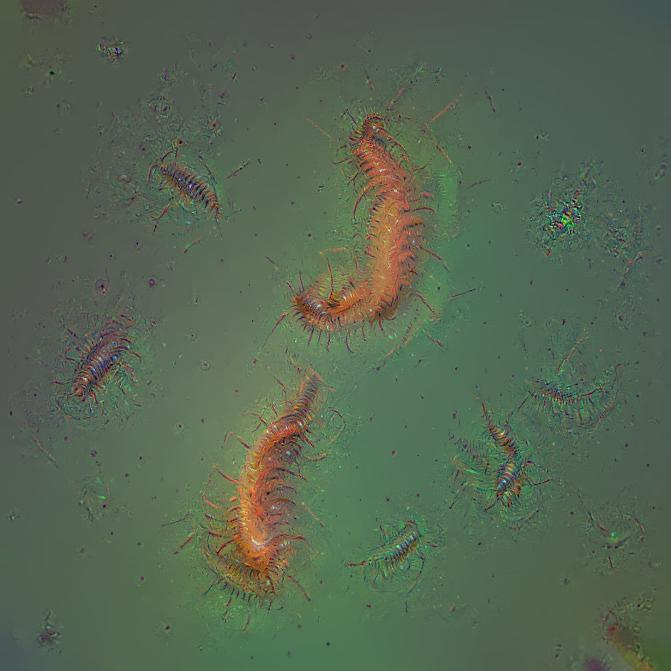

finished step 0 in octave 7
finished step 10 in octave 7
finished step 20 in octave 7
finished step 30 in octave 7
octave 7 image:


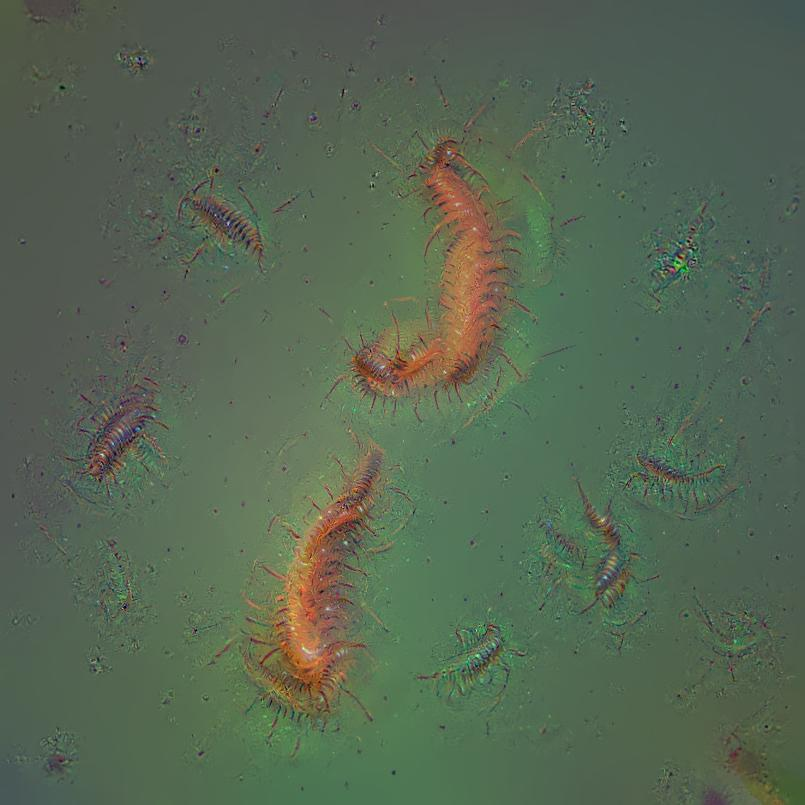

finished step 0 in octave 8
finished step 10 in octave 8
finished step 20 in octave 8
octave 8 image:


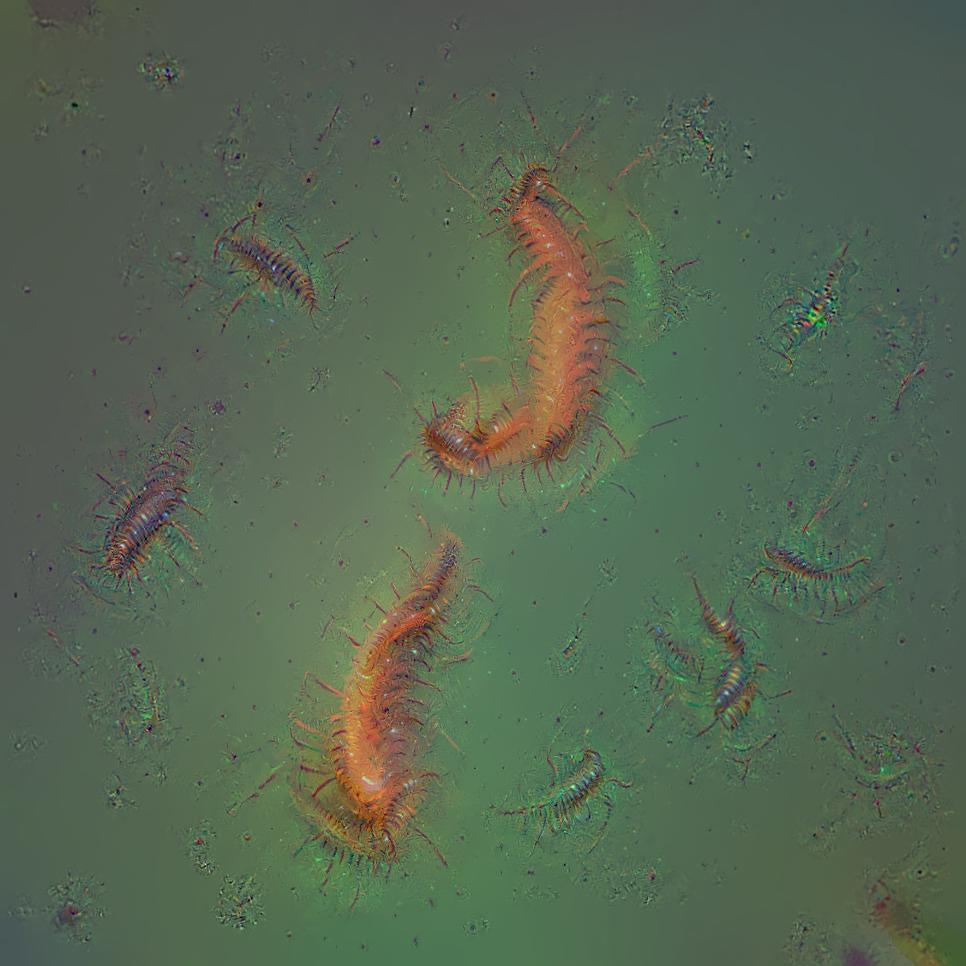

finished step 0 in octave 9
finished step 10 in octave 9
octave 9 image:


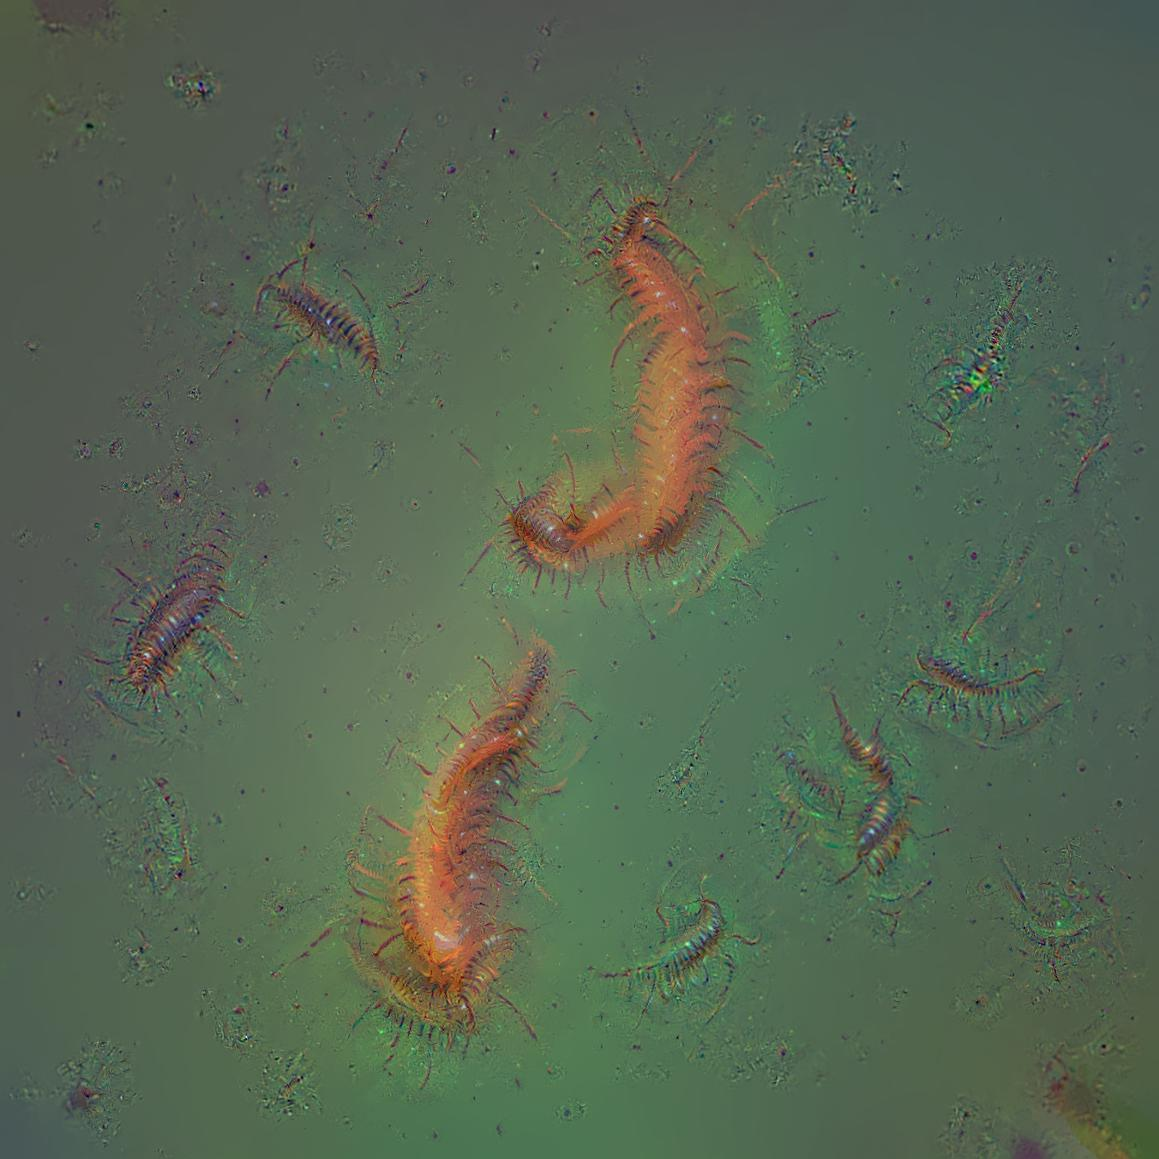

finished step 0 in octave 10
finished step 10 in octave 10
octave 10 image:


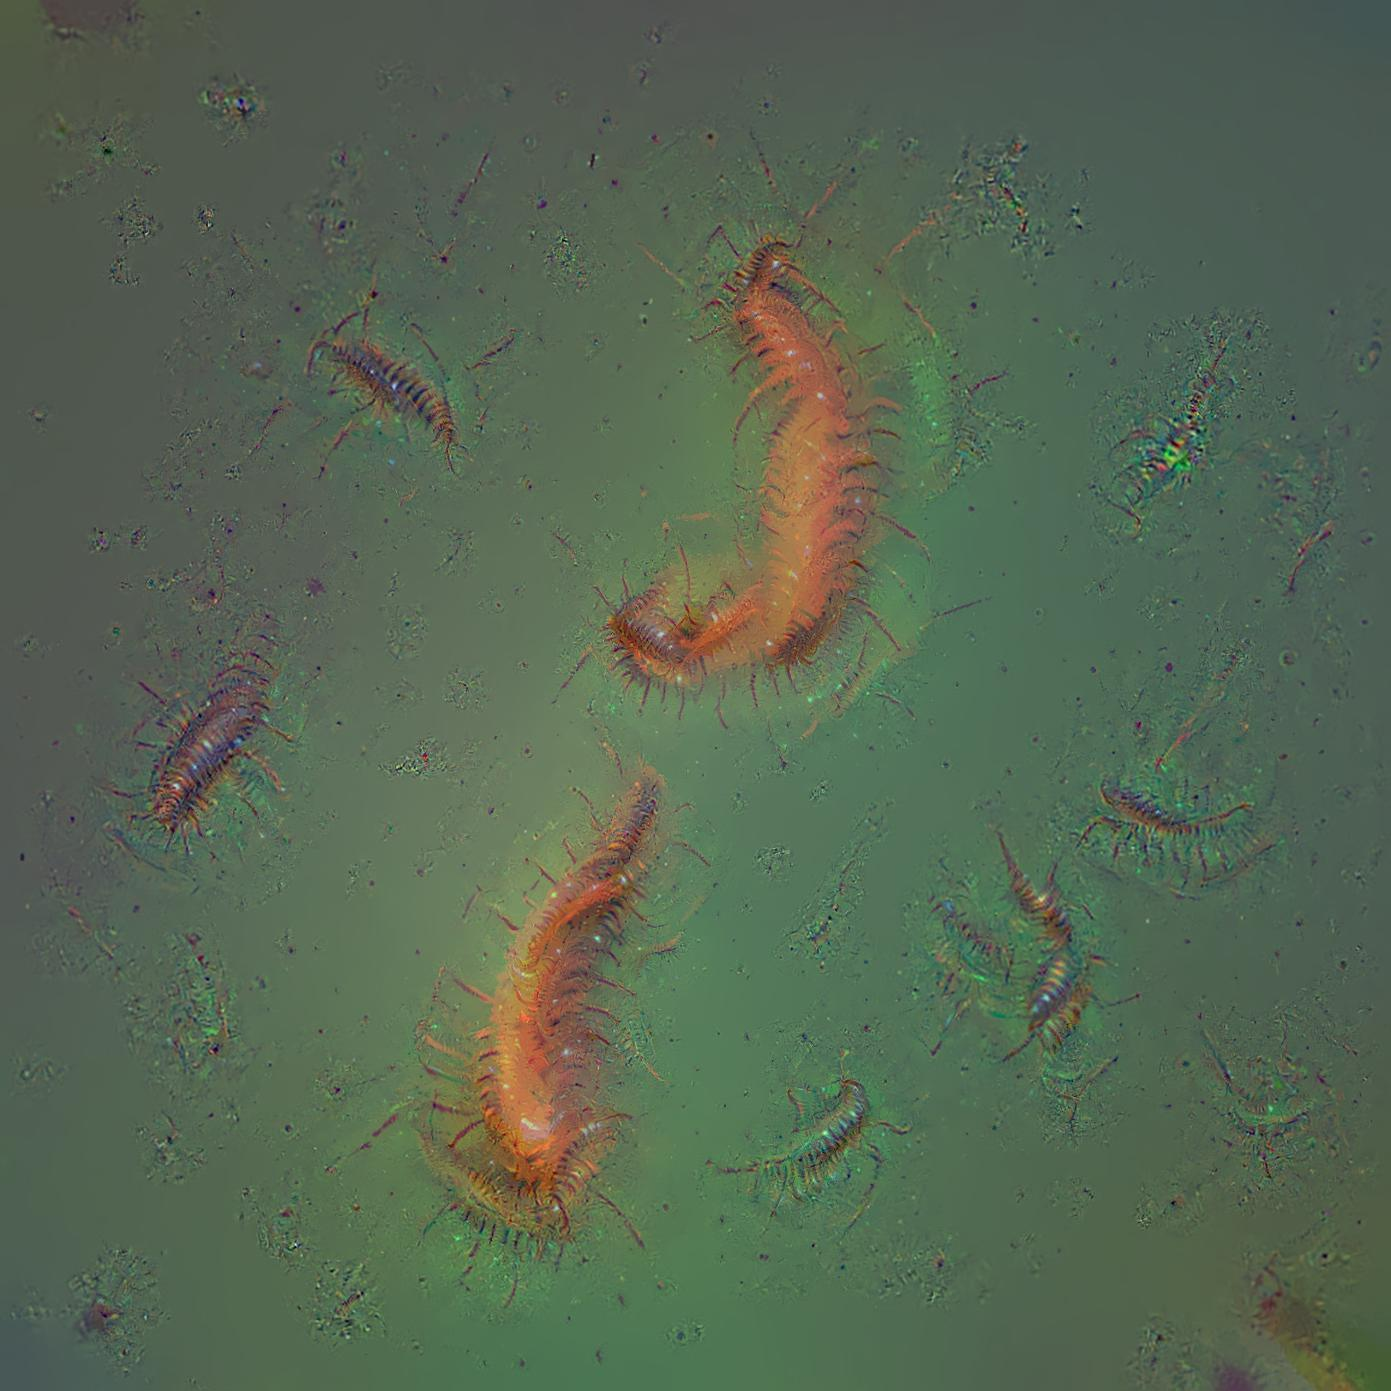

finished step 0 in octave 11
finished step 10 in octave 11
octave 11 image:


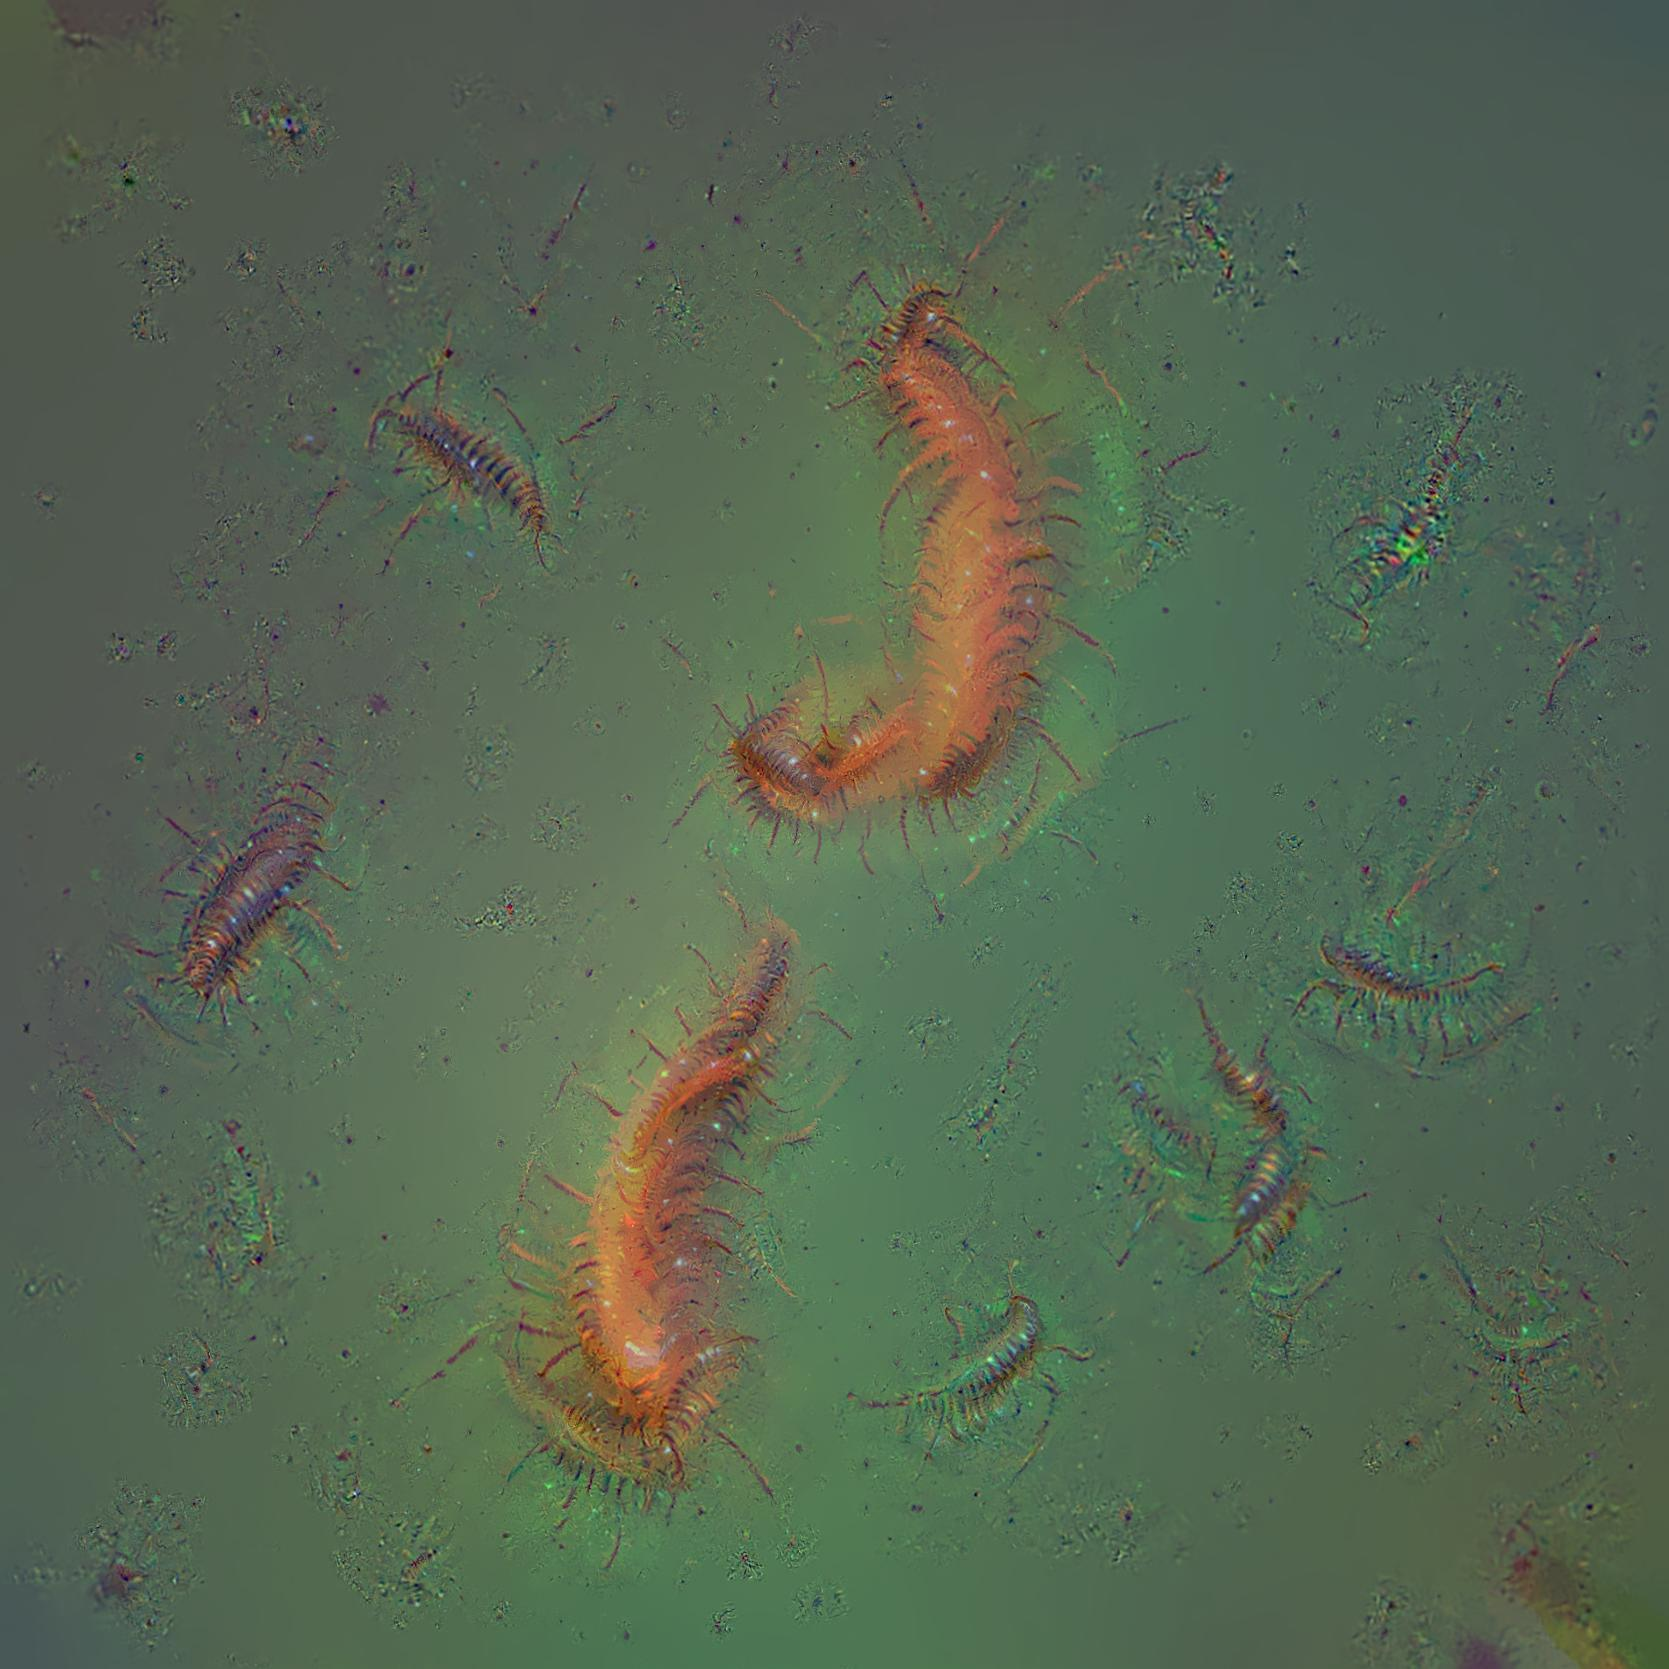

finished step 0 in octave 12
finished step 10 in octave 12
octave 12 image:


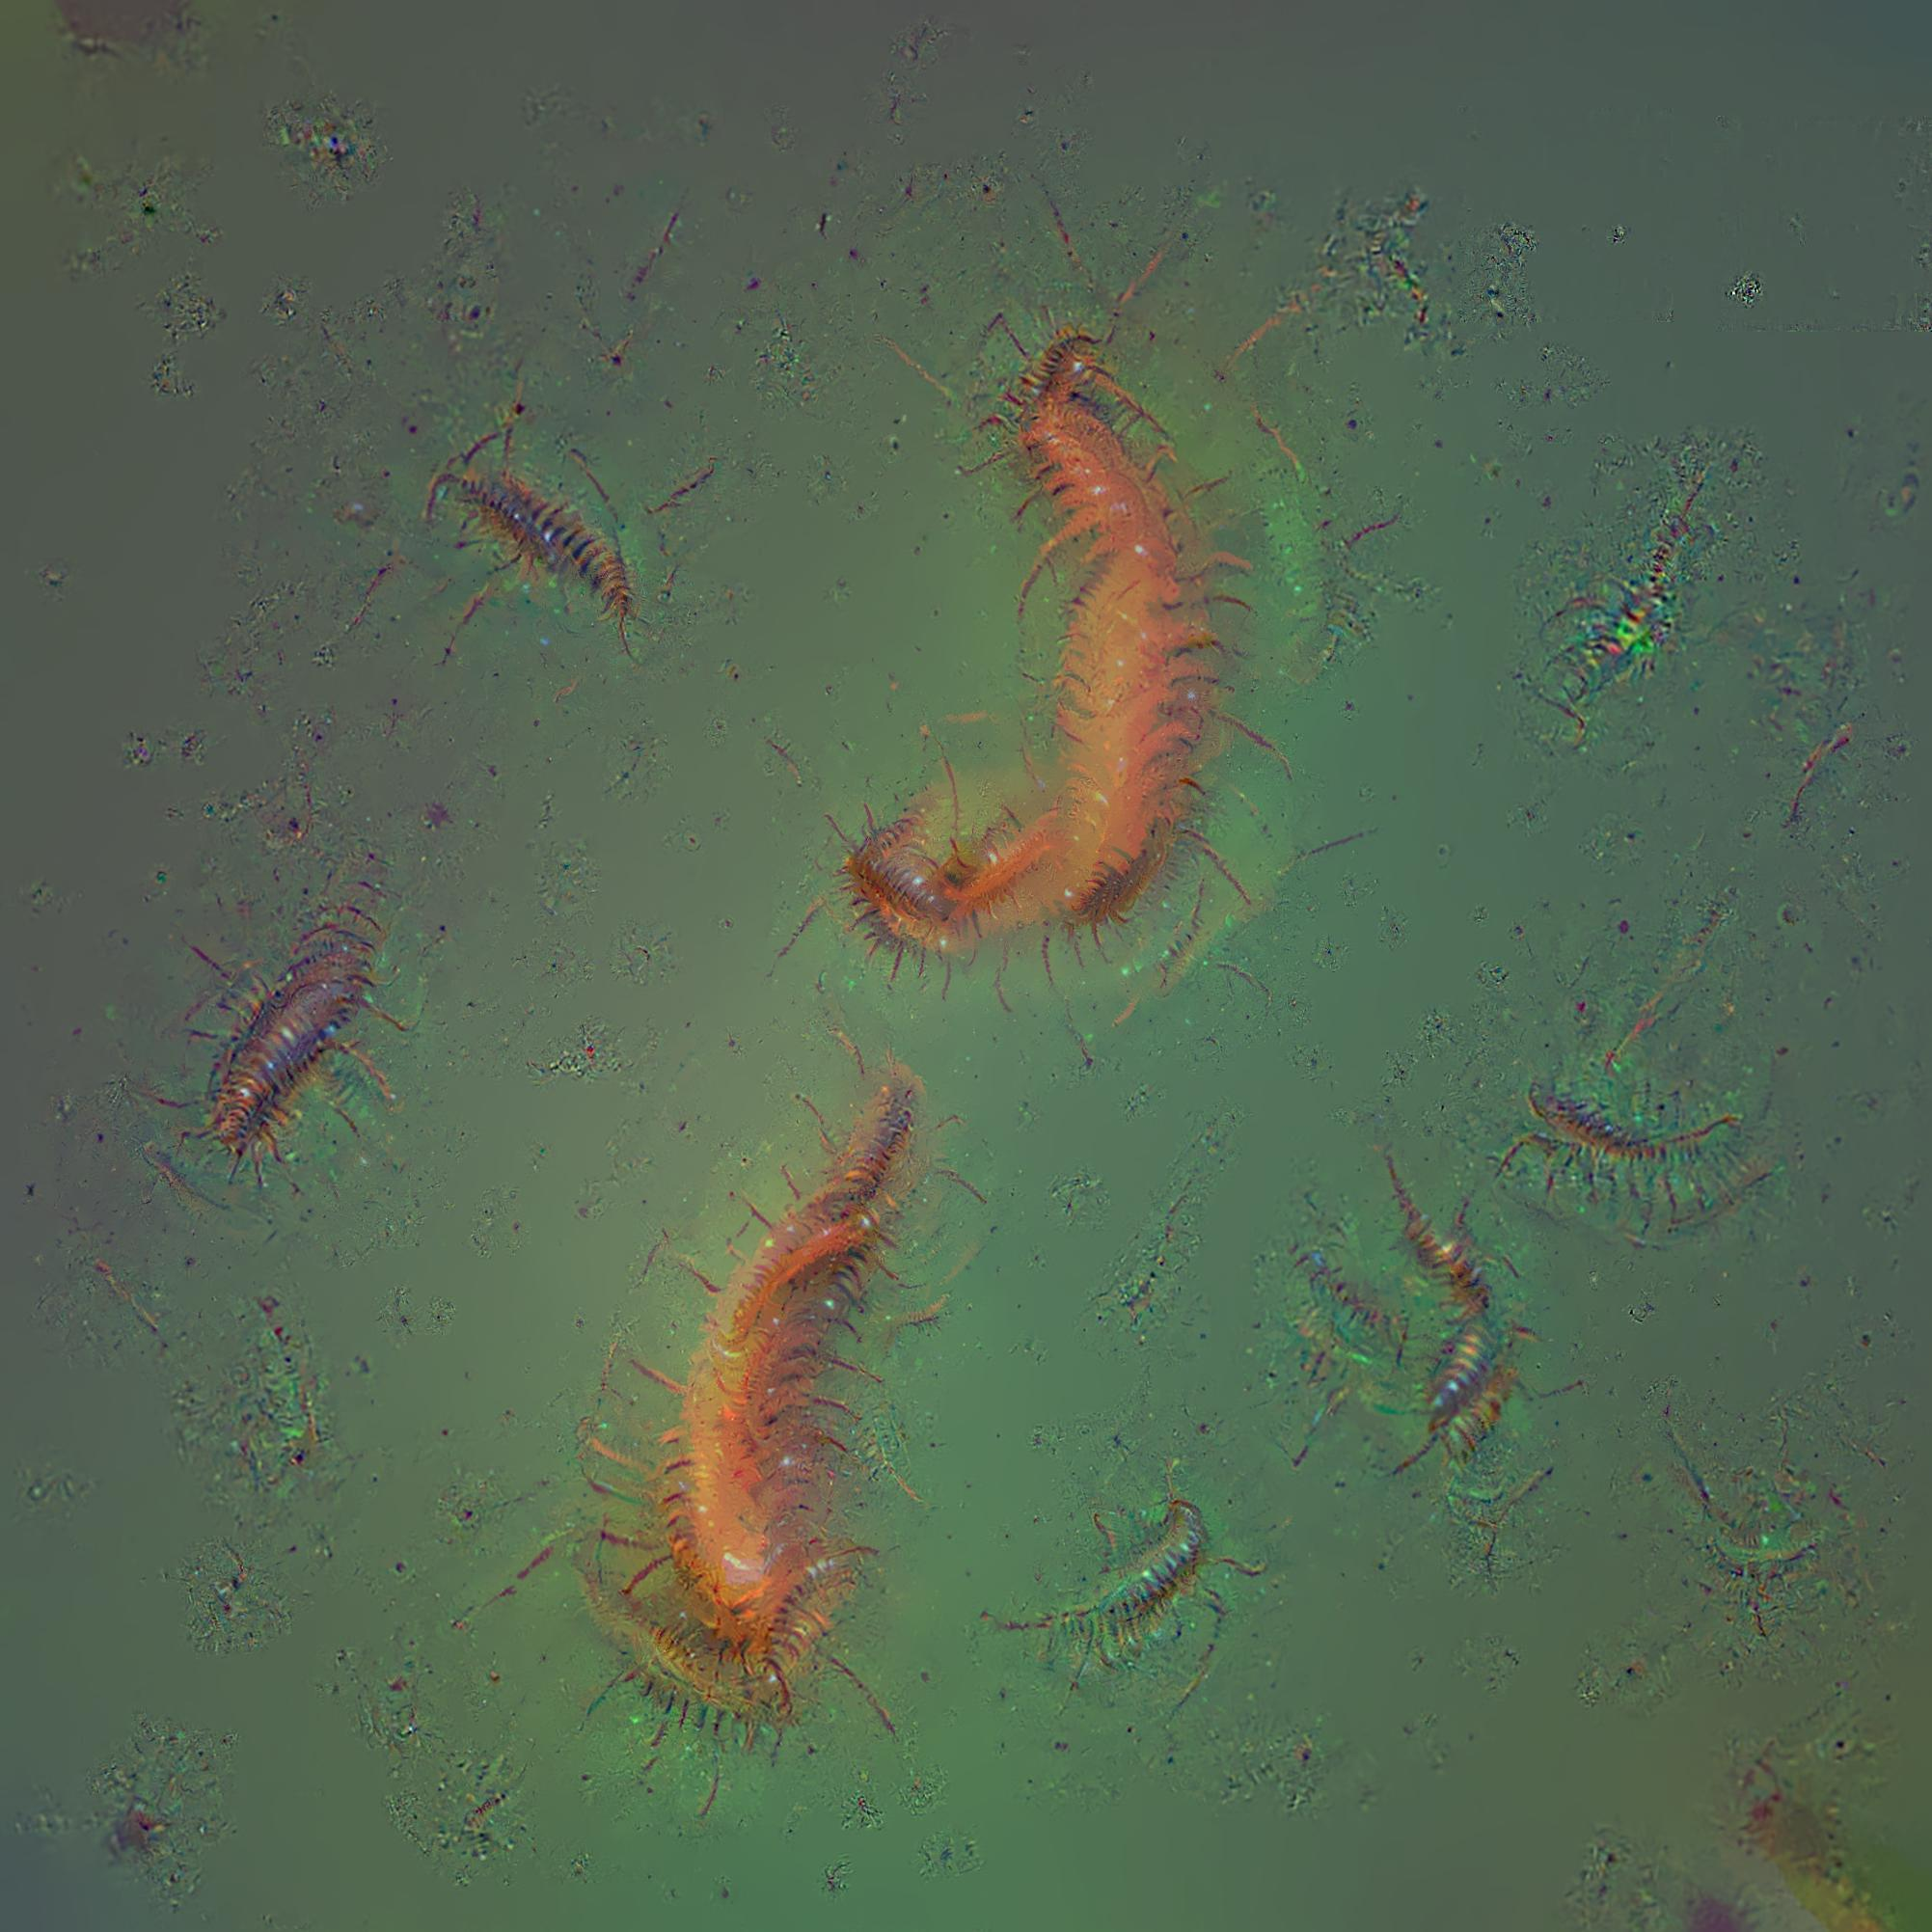

finished step 0 in octave 13
finished step 10 in octave 13
finished step 20 in octave 13
octave 13 image:


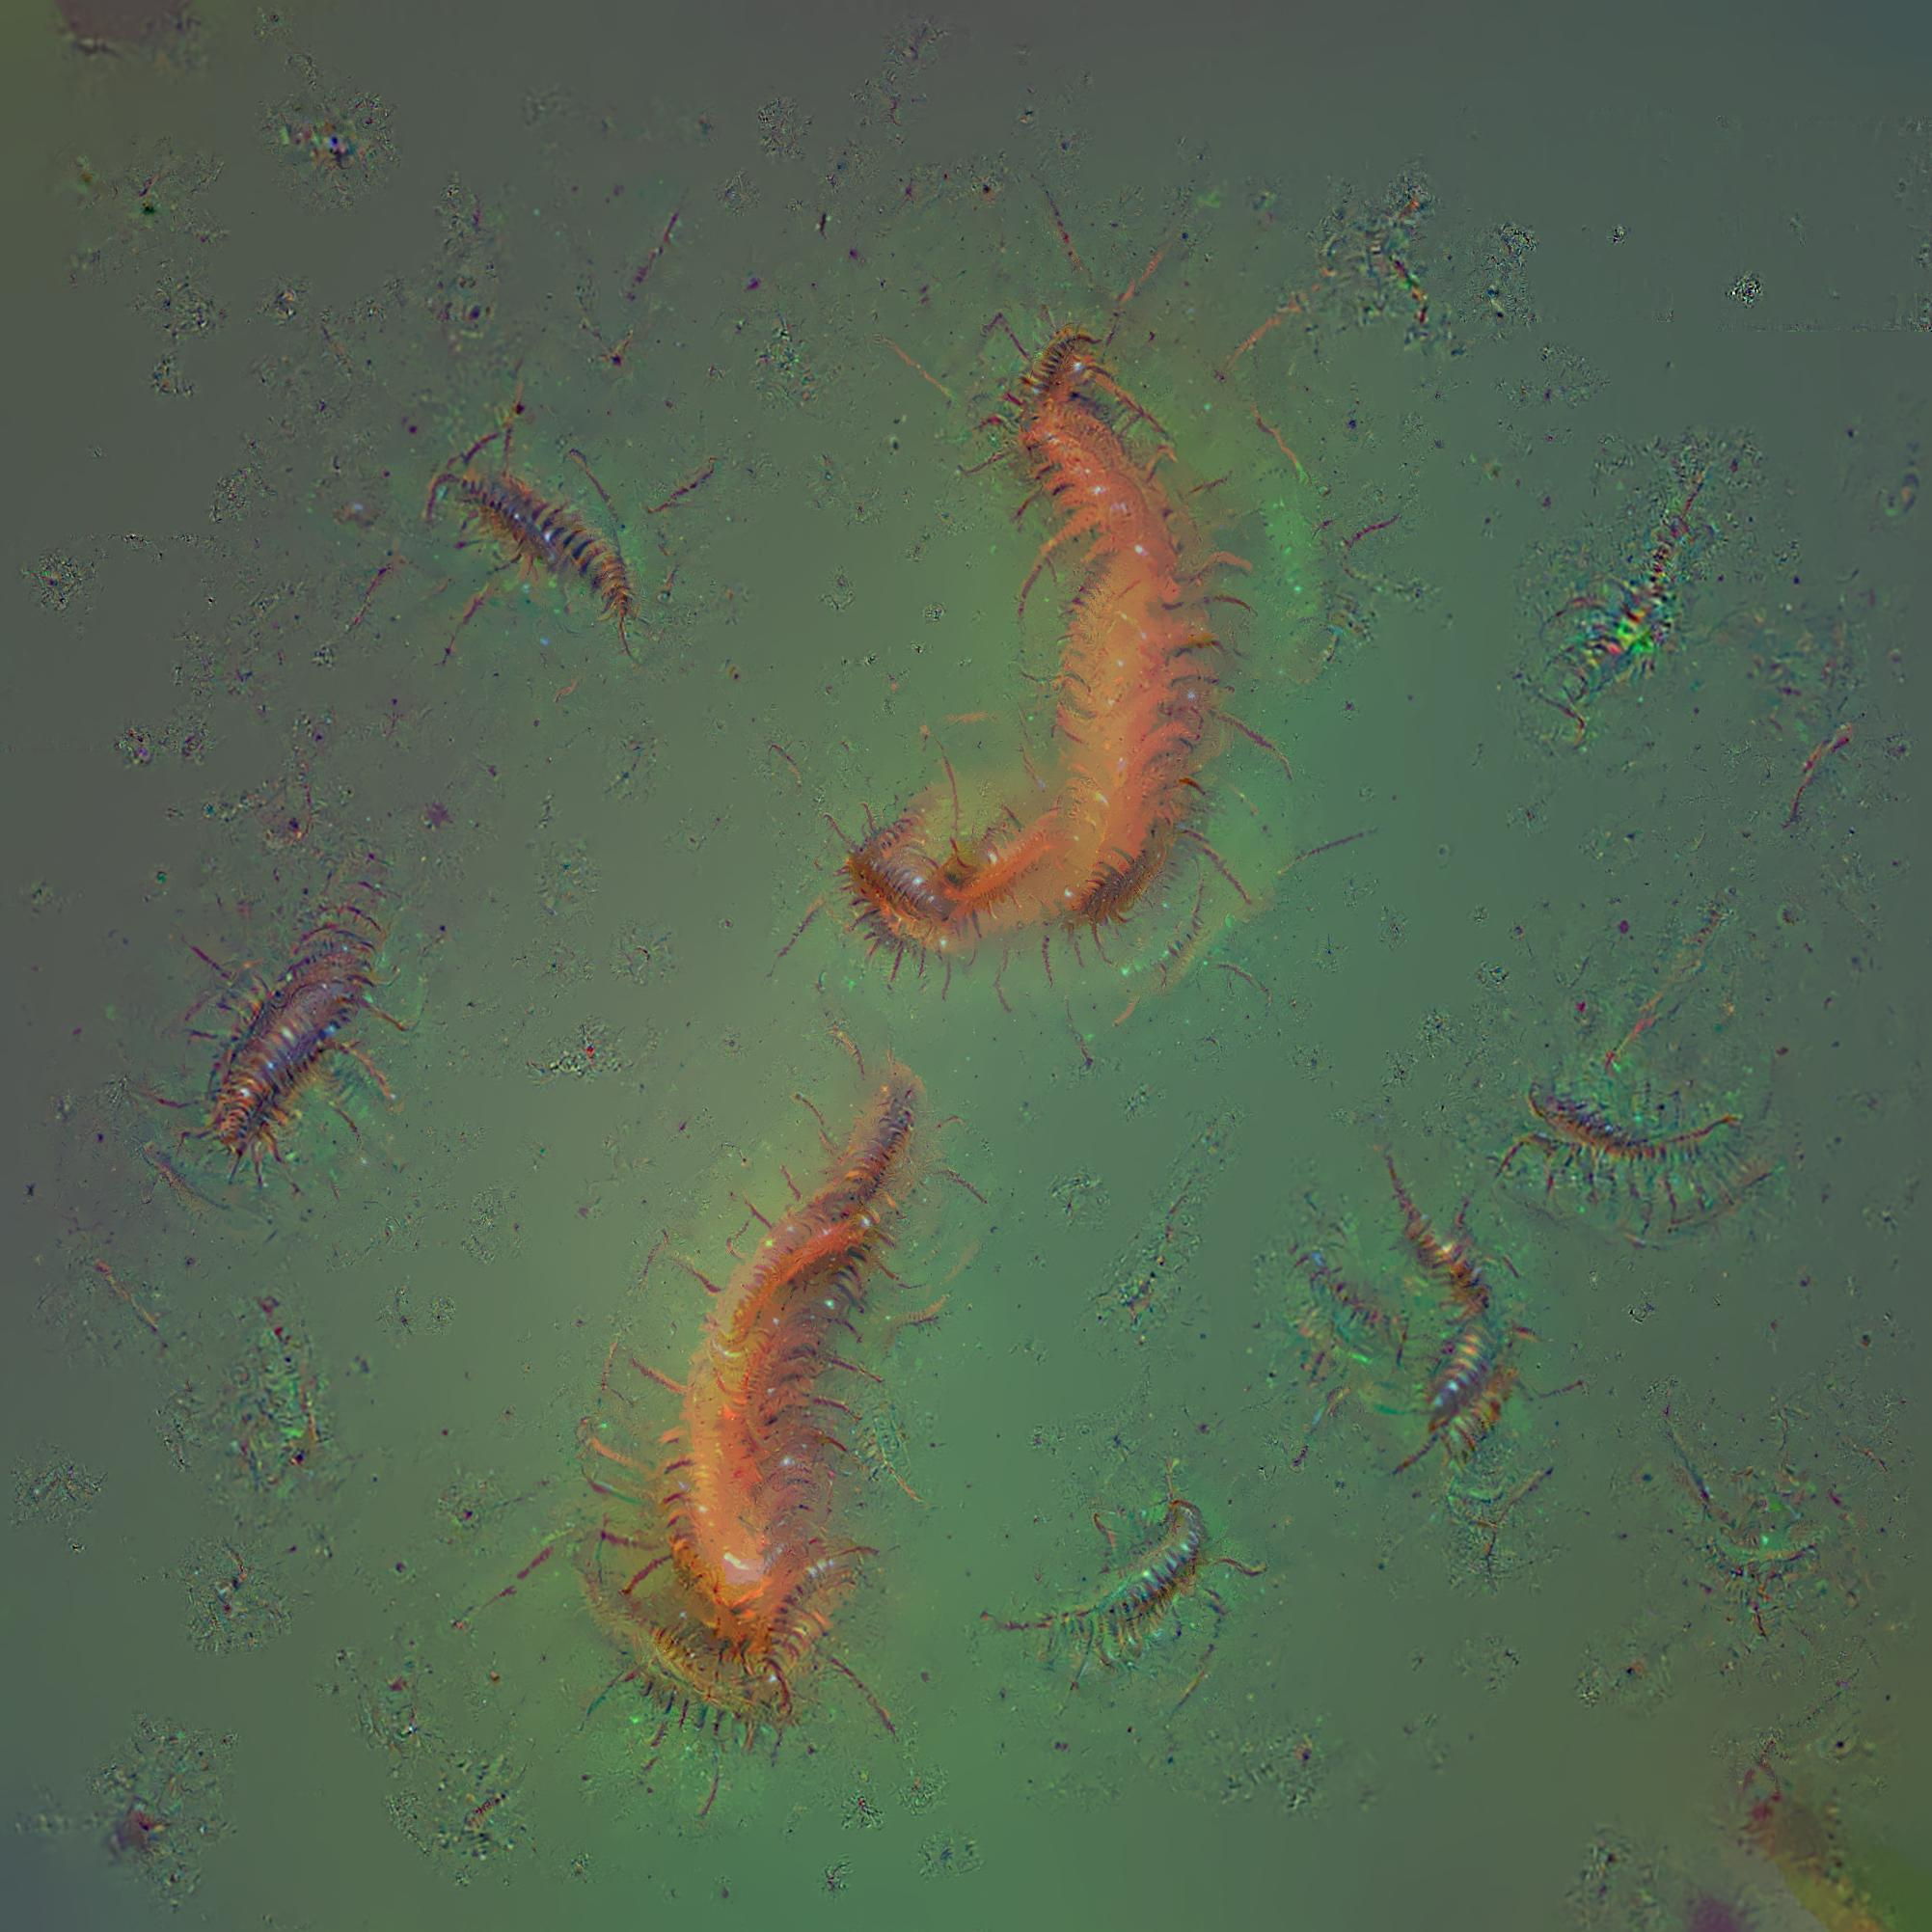

'\nfor i in range(0,100): # Automate image visualization and writing to disk\n    imagenet_class = i\n    gen_image = np.random.normal(background_color, 8, (original_w, original_h, 3)) # create image of random noise with dimensions of input image\n    gen_image = deepdraw(net, gen_image, octaves, focus=imagenet_class, random_crop=True)\n    img_fn = \'_\'.join([model_name, "deepdraw_denoised", str(imagenet_class)+\'.png\'])\n    PIL.Image.fromarray(cv2.bilateralFilter(np.uint8(gen_image), -1, 25, 6)).save(\'./\' + img_fn) # Very strong bilateral filter after visualization\n    # PIL.Image.fromarray(np.uint8(gen_image)).save(\'./\' + img_fn)                               # This "cartoonifies" the image\n'

In [10]:
# these octaves are where bulk of tuning occurs, they determine gradient ascent steps
octaves = [
    {
        'layer':'loss3/classifier',   # layer to perform image updates from
        'iter_n':190,                 # number of times to perform image update
        'start_sigma':2.5,            # Gradually reduce gaussian blur as recommended by 
        'end_sigma':0.78,             #   https://github.com/kylemcdonald/deepdream
        'start_step_size':11.,        # Gradually change step size of gradient ascent as recommended by 
        'end_step_size':11.           #   http://www.auduno.com/2015/07/29/visualizing-googlenet-classes/
    },
    {
        'layer':'loss3/classifier',
        'scale':1.2,
        'iter_n':150,
        'start_sigma':0.78*1.2,
        'end_sigma':0.78,
        'start_step_size':6.,
        'end_step_size':6.
    },
    {
        'layer':'loss3/classifier',
        'scale':1.2,
        'iter_n':70,
        'start_sigma':0.78*1.2,
        'end_sigma':0.44,
        'start_step_size':6.,
        'end_step_size':3.
    },
    {
        'layer':'loss3/classifier',
        'scale':1.2,
        'iter_n':50,
        'start_sigma':0.44,
        'end_sigma':0.304,
        'start_step_size':3.,
        'end_step_size':3.
    },
    {
        'layer':'loss3/classifier',
        'scale':1.2,
        'iter_n':30,
        'start_sigma':0.44,
        'end_sigma':0.304,
        'start_step_size':3.,
        'end_step_size':3.
    },
    {
        'layer':'loss2/classifier',
        'scale':1.2,
        'iter_n':150,
        'start_sigma':0.44,
        'end_sigma':0.304,
        'start_step_size':3.,
        'end_step_size':3.
    },
    {
        'layer':'loss2/classifier',
        'scale':1.2,
        'iter_n':70,
        'start_sigma':0.44,
        'end_sigma':0.304,
        'start_step_size':3.,
        'end_step_size':3.
    },
    {
        'layer':'loss2/classifier',
        'scale':1.2,
        'iter_n':40,
        'start_sigma':0.44,
        'end_sigma':0.304,
        'start_step_size':3.,
        'end_step_size':3.
    },
    {
        'layer':'loss2/classifier',
        'scale':1.2,
        'iter_n':30,
        'start_sigma':0.44,
        'end_sigma':0.304,
        'start_step_size':3.,
        'end_step_size':3.
    },
    {
        'layer':'loss2/classifier',
        'scale':1.2,
        'iter_n':20,
        'start_sigma':0.44,
        'end_sigma':0.304,
        'start_step_size':3.,
        'end_step_size':3.
    },
    {
        'layer':'loss2/classifier',
        'scale':1.2,
        'iter_n':20,
        'start_sigma':0.44,
        'end_sigma':0.304,
        'start_step_size':3.,
        'end_step_size':3.
    },
    {
        'layer':'loss1/classifier',
        'scale':1.2,
        'iter_n':20,
        'start_sigma':0.44,
        'end_sigma':0.304,
        'start_step_size':3.,
        'end_step_size':3.
    },
    {
        'layer':'loss1/classifier',
        'scale':1.2,
        'iter_n':20,
        'start_sigma':0.44,
        'end_sigma':0.304,
        'start_step_size':3.,
        'end_step_size':3.
    },
    {
        'layer':'loss1/classifier',
        'iter_n':30,
        'start_sigma':0.44,
        'end_sigma':0.304,
        'start_step_size':3.,
        'end_step_size':3.
    }
]

# get original image input size from network
original_w = net.blobs['data'].width
original_h = net.blobs['data'].height
# the background color of the initial image
# background_color = np.float32([28.0, 84.0, 122.0]) # This is blue 
background_color = np.float32([70, 83, 82])

imagenet_class = 79
gen_image = np.random.normal(background_color, 8, (original_w, original_h, 3)) # create image of random noise with dimensions of input image
gen_image = deepdraw(net, gen_image, octaves, focus=imagenet_class, random_crop=True)
img_fn = '_'.join([model_name, "deepdraw_denoised", str(imagenet_class)+'.png'])


"""
for i in range(0,100): # Automate image visualization and writing to disk
    imagenet_class = i
    gen_image = np.random.normal(background_color, 8, (original_w, original_h, 3)) # create image of random noise with dimensions of input image
    gen_image = deepdraw(net, gen_image, octaves, focus=imagenet_class, random_crop=True)
    img_fn = '_'.join([model_name, "deepdraw_denoised", str(imagenet_class)+'.png'])
    PIL.Image.fromarray(cv2.bilateralFilter(np.uint8(gen_image), -1, 25, 6)).save('./' + img_fn) # Very strong bilateral filter after visualization
    # PIL.Image.fromarray(np.uint8(gen_image)).save('./' + img_fn)                               # This "cartoonifies" the image
"""

In [ ]:
PIL.Image.fromarray(cv2.bilateralFilter(np.uint8(gen_image), -1, 25, 6)).save('./' + img_fn) # Very strong bilateral filter after visualization

Less scaling and more iterations gives lower resolution but more coherent image

starting drawing
finished step 0 in octave 0
finished step 10 in octave 0
finished step 20 in octave 0
finished step 30 in octave 0
finished step 40 in octave 0
finished step 50 in octave 0
finished step 60 in octave 0
finished step 70 in octave 0
finished step 80 in octave 0
finished step 90 in octave 0
finished step 100 in octave 0
finished step 110 in octave 0
finished step 120 in octave 0
finished step 130 in octave 0
finished step 140 in octave 0
finished step 150 in octave 0
finished step 160 in octave 0
finished step 170 in octave 0
finished step 180 in octave 0
octave 0 image:


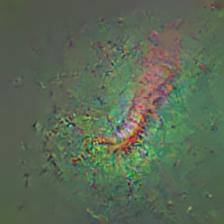

/home/s/anaconda2/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


finished step 0 in octave 1
finished step 10 in octave 1
finished step 20 in octave 1
finished step 30 in octave 1
finished step 40 in octave 1
finished step 50 in octave 1
finished step 60 in octave 1
finished step 70 in octave 1
finished step 80 in octave 1
finished step 90 in octave 1
finished step 100 in octave 1
finished step 110 in octave 1
finished step 120 in octave 1
finished step 130 in octave 1
finished step 140 in octave 1
finished step 150 in octave 1
finished step 160 in octave 1
finished step 170 in octave 1
finished step 180 in octave 1
finished step 190 in octave 1
finished step 200 in octave 1
finished step 210 in octave 1
finished step 220 in octave 1
finished step 230 in octave 1
finished step 240 in octave 1
finished step 250 in octave 1
finished step 260 in octave 1
finished step 270 in octave 1
finished step 280 in octave 1
finished step 290 in octave 1
finished step 300 in octave 1
finished step 310 in octave 1
finished step 320 in octave 1
finished step 330 in 

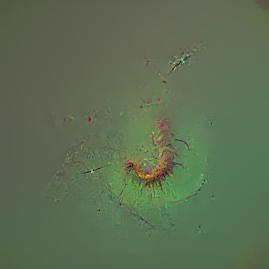

In [6]:
octaves = [
    {
        'layer':'loss3/classifier',
        'iter_n':190,
        'start_sigma':2.5,
        'end_sigma':0.78,
        'start_step_size':11.,
        'end_step_size':11.
    },
    {
        'layer':'loss3/classifier',
        'scale':1.2,
        'iter_n':450,
        'start_sigma':0.78*1.2,
        'end_sigma':0.40,
        'start_step_size':6.,
        'end_step_size':3.
    }
]

# get original image input size from network
original_w = net.blobs['data'].width
original_h = net.blobs['data'].height
# the background color of the initial image
# background_color = np.float32([28.0, 84.0, 122.0]) # This is blue 
background_color = np.float32([70, 83, 82])

imagenet_class = 79
gen_image = np.random.normal(background_color, 8, (original_w, original_h, 3))
gen_image = deepdraw(net, gen_image, octaves, focus=imagenet_class, 
                 random_crop=True)

#img_fn = '_'.join([model_name, "deepdraw", str(imagenet_class)+'.png'])
#PIL.Image.fromarray(np.uint8(gen_image)).save('./' + img_fn)

The choices below give images that are not as large as in first set of automation, but are more coherent

In [ ]:
octaves = [
    {
        'layer':'loss3/classifier',
        
        'iter_n':190,
        'start_sigma':2.5,
        'end_sigma':0.78,
        'start_step_size':11.,
        'end_step_size':11.
    },
    {
        'layer':'loss3/classifier',
        'scale':1.2,
        'iter_n':100,
        'start_sigma':0.78*1.2,
        'end_sigma':0.65,
        'start_step_size':6.,
        'end_step_size':6.
    },
    {
        'layer':'loss2/classifier',
        'scale':1.2,
        'iter_n':90,
        'start_sigma':0.78*1,
        'end_sigma':0.55,
        'start_step_size':6.,
        'end_step_size':3.
    },
    {
        'layer':'loss2/classifier',
        'scale':1.2,
        'iter_n':60,
        'start_sigma':0.78*0.8,
        'end_sigma':0.45,
        'start_step_size':6.,
        'end_step_size':3.
    },
    {
        'layer':'loss1/classifier',
        'scale':1.2,
        'iter_n':10,
        'start_sigma':0.45,
        'end_sigma':0.304,
        'start_step_size':3.,
        'end_step_size':3.
    },
    {
        'layer':'loss1/classifier',
        'iter_n':5,
        'start_sigma':0.304,
        'end_sigma':0.2,
        'start_step_size':3.,
        'end_step_size':1.
    }
]

background_color = np.float32([85.0, 98.0, 112.0]) # "Slate" color -- tends to not work as well as blue with bilateral filter

for i in range(901,1000):
    imagenet_class = i
    gen_image = np.random.normal(background_color, 8, (original_w, original_h, 3))
    gen_image = deepdraw(net, gen_image, octaves, focus=imagenet_class, random_crop=True)
    img_fn = '_'.join([model_name, "deepdraw_denoised", str(imagenet_class)+'.png'])
    PIL.Image.fromarray(cv2.bilateralFilter(np.uint8(gen_image), -1, 25, 6)).save('./' + img_fn)
    # PIL.Image.fromarray(np.uint8(gen_image)).save('./' + img_fn)